In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rbo

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics

sys.path.append("/home/dhoof/master-thesis-automatic-selection/benchmark/metrics-analysis")
sys.path.append("/home/dhoof/pytorch-pretrained-cnns")
from metrics.loader import CheckpointLoader, MetricsLoader
from metrics.loader.calculate_metrics import ArchitectureSizeMetrics, QualityMetrics, LatentSpaceMetrics, InformationalMetrics
from metrics.analysis.random_forest_pipeline import RandomForestPipeline
from metrics.analysis.random_forest_pca_pipeline import RandomForestPCAPipeline

/home/dhoof/.conda/envs/pytorch111/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Static Parameters
pretrained_checkpoints_path="output/"
pretrained_checkpoint=(0, "pretrained")
pretrained_datasets=[("cifar10", 100), ("cifar100", 100), ("svhn", 100), ("tinyimagenet", 100)]

finetune_checkpoints_path="output_sweep_complete/"
finetune_checkpoints=[
    (0,"cifar10_model"),
    (1,"cifar100_model"),
    # (2,"grocerystore_model"),
    (3,"svhn_model"),
    (4,"tinyimagenet_model")
]
finetune_datasets=[("cifar10", 5), ("cifar100", 5), ("svhn", 5), ("tinyimagenet", 5)]
from_scratch_checkpoint=(5, "from_scratch")

models=["lowres_resnet9","lowres_resnet50","lowres_densenet121","lowres_vgg16_bn"]
all_datasets_path="../SSD/datasets"

use_cached_df_if_available=True
# cache_csv_path="full_metrics_kmeans_df.csv"
replace_cache = False

target='difference'

# hyperparameters

def get_metrics(mode, cluster_algorithm=None):
    if mode == "static":
        return [
            QualityMetrics(),
            ArchitectureSizeMetrics()
        ]
    if mode == "dynamic":
        return [
            # QualityMetrics(),
            # ArchitectureSizeMetrics(),
            LatentSpaceMetrics(cluster_model_name=cluster_algorithm)
        ]
    if mode == "both":
        return [
            QualityMetrics(),
            ArchitectureSizeMetrics(),
            LatentSpaceMetrics(cluster_model_name=cluster_algorithm)
        ]
    
def get_features(feature_selection, metrics_range, df):    
    if feature_selection == 'all_parameters':
        return df.loc[:, ~df.columns.isin(['checkpoint', 'finetune_dataset','model','pretrained_dataset',"dataset",'difference'])].columns
    if feature_selection == 'selected_parameters':
        if metrics_range == 'static':
            return [
              'sparsity',
              # 'variance_entropy',
              'variance_entropy_clean',
              # 'weighted_sparsity',
              # 'weighted_variance_entropy',
              # 'weighted_variance_entropy_clean',    
              'architecture_size',
              # 'architecture_size_conv',
              # 'architecture_size_pool',
              # 'architecture_size_relu',
              # 'model_lowres_densenet121',
              # 'model_lowres_resnet50',
              # 'model_lowres_resnet9',
              # 'model_lowres_vgg16_bn',
              # 'pretrained_dataset_cifar10',
              # 'pretrained_dataset_cifar100',
              # 'pretrained_dataset_svhn',
              # 'pretrained_dataset_tinyimagenet',
              # 'latent_space_silhouette_score'
             ] 
        if metrics_range == 'dynamic':
            return [
              'sparsity',
              # 'variance_entropy',
              'variance_entropy_clean',
              # 'weighted_sparsity',
              # 'weighted_variance_entropy',
              # 'weighted_variance_entropy_clean',    
              # 'architecture_size',
              # 'architecture_size_conv',
              # 'architecture_size_pool',
              # 'architecture_size_relu',
              # 'model_lowres_densenet121',
              # 'model_lowres_resnet50',
              # 'model_lowres_resnet9',
              # 'model_lowres_vgg16_bn',
              # 'pretrained_dataset_cifar10',
              # 'pretrained_dataset_cifar100',
              # 'pretrained_dataset_svhn',
              # 'pretrained_dataset_tinyimagenet',
              'latent_space_silhouette_score'
             ] 

metrics_ranges=[
    'static',
    'dynamic',
    'both'
]

clustering_algorithms=[
    'kmeans',
    'dbscan'
]

feature_selections=[
    'all_parameters',
    'selected_parameters'
]

In [5]:
hyperparameters = []

for metrics_range in metrics_ranges:
    for cluster_algorithm in clustering_algorithms:
        for feature_selection in feature_selections:
            name = f"{metrics_range}_{cluster_algorithm}_{feature_selection}"
            # print(name)
            # print(get_metrics(metrics_range, cluster_algorithm))

            metrics_loader = MetricsLoader(
                        pretrained_cp_loader=CheckpointLoader(pretrained_checkpoints_path, all_datasets_path),
                        pretrained_checkpoint=pretrained_checkpoint,
                        finetune_cp_loader=CheckpointLoader(finetune_checkpoints_path, all_datasets_path),
                        finetune_checkpoints=finetune_checkpoints,
                        from_scrape_cp_loader=CheckpointLoader(finetune_checkpoints_path, all_datasets_path),
                        from_scratch_checkpoint=from_scratch_checkpoint,
                        metrics=get_metrics(metrics_range, cluster_algorithm),
                        finetune_datasets=finetune_datasets,
                        pretrained_datasets=pretrained_datasets,
                        models=models,
                        use_finetune_dataset=False
                    )
            
            if use_cached_df_if_available and os.path.exists(f"cache/{name}.csv") and not replace_cache:
                metrics_df=pd.read_csv(f"cache/{name}.csv",index_col=[0])
            else:
                metrics_df=metrics_loader.load_all_metrics()
                
            if not os.path.exists(f"cache/{name}.csv") or replace_cache:
                metrics_df.to_csv(f"cache/{name}.csv")
            
            if metrics_range == "static" or metrics_range == "both":
                ohe_df=pd.concat([metrics_df,pd.get_dummies(metrics_df['model'], prefix='model'),pd.get_dummies(metrics_df['pretrained_dataset'], prefix='pretrained_dataset'),pd.get_dummies(metrics_df['finetune_dataset'], prefix='finetune_dataset')],axis=1).fillna(0)
            else:
                ohe_df=metrics_df
            
            features = get_features(feature_selection, metrics_range, ohe_df)

            hyperparameters.append((name, ohe_df, features))
            

In [6]:
def calculate_rbo(pipeline, df, X, y):
    info_df=df[df['difference'].isin(y)]
    
    assignment_list=list(zip(list(pipeline.predict(X)),list(y)))
    
    rank_df = pd.DataFrame.from_records(assignment_list, columns=['difference_predict','difference'])
    
    df_ranking = info_df.merge(rank_df, on='difference', how='inner')
    
    difference_ranking=list(df_ranking[['finetune_dataset','model','pretrained_dataset','difference']].sort_values(by="difference",ascending=False).index)
    difference_predicted_ranking=list(df_ranking[['finetune_dataset','model','pretrained_dataset','difference_predict']].sort_values(by="difference_predict",ascending=False).index)
    
    return rbo.RankingSimilarity(difference_ranking,difference_predicted_ranking).rbo()

In [7]:
def calculate_ranking(pipeline, df, X, y):
    info_df=df[df['difference'].isin(y)]
    
    assignment_list=list(zip(list(pipeline.predict(X)),list(y)))
    
    rank_df = pd.DataFrame.from_records(assignment_list, columns=['difference_predict','difference'])
    
    df_ranking = info_df.merge(rank_df, on='difference', how='inner')
    ranking_predict = np.array(list(df_ranking[['finetune_dataset','model','pretrained_dataset','difference','difference_predict']].sort_values(by="difference_predict",ascending=False)['difference']))
    ranking_real = np.array(list(df_ranking[['finetune_dataset','model','pretrained_dataset','difference','difference_predict']].sort_values(by="difference",ascending=False)['difference']))    
   
    return ranking_predict, ranking_real

In [8]:
def calculate_predict_diff(pipeline, df, X, y):
    info_df=df[df['difference'].isin(y)]
    
    assignment_list=list(zip(list(pipeline.predict(X)),list(y)))
    
    predict_df = pd.DataFrame.from_records(assignment_list, columns=['difference_predict','difference'])
    df = info_df.merge(predict_df, on='difference', how='inner')
    return df

In [9]:
from typing import List, Optional, Union
class RankingSimilarity:
    def __init__(
            self,
            S: Union[List, np.ndarray],
            T: Union[List, np.ndarray]
    ):        

        assert type(S) in [list, np.ndarray]
        assert type(T) in [list, np.ndarray]

        assert len(S) == len(S)
        assert len(T) == len(T)
        
        S = np.array(S)
        T = np.array(T)

        self.S, self.T = S, T
        self.N_S, self.N_T = len(S), len(T)
        
    def _normalize(self, V: Union[List, np.ndarray], inverse=False):
        V = np.array(V)
        V_min = np.min(V)
        V_max = np.max(V)
        if inverse == True:
            # the diff metric sees a smaller value as higher, also as max value
            V_min = np.max(V)
            V_max = np.min(V)
            
        return ((V - V_min) / (V_max - V_min))
        
        
    def diff_metric(self, c=1, weight_func=lambda x: 2 ** x):
        if c > self.N_S:
            c = self.N_S
        # print(self.S-np.max(self.T))
        # print(self._normalize(self.S-np.max(self.T)))
        #return np.sum(self.S*np.pad(weight_func(np.arange(c+1, 1 ,-1)), (0, self.N_S-c), constant_values=1)-self.T*np.pad(weight_func(np.arange(c+1, 1 ,-1)), (0, self.N_T-c), constant_values=1))
        # print(self._normalize(self.S-np.max(self.T))*np.pad(weight_func(np.arange(c+1, 1 ,-1)), (0, self.N_S-c), constant_values=1) / np.sum(np.pad(weight_func(np.arange(c+1, 1 ,-1)), (0, self.N_S-c), constant_values=1)))
        return np.sum(self._normalize(self.S-self.T)*np.pad(weight_func(np.arange(c+1, 1 ,-1)), (0, self.N_S-c), constant_values=1))/np.sum(np.pad(weight_func(np.arange(c+1, 1 ,-1)), (0, self.N_S-c), constant_values=1))
    
    
    # def diff_metric_rel(self, c=1, weight_func=lambda x: 2 ** x):
    #     print(self.S-self.T)
    #     return np.sum(self._normalize(self.S-self.T)*np.pad(weight_func(np.arange(c+1, 1 ,-1)), (0, self.N_S-c), constant_values=1))/np.sum(np.pad(weight_func(np.arange(c+1, 1 ,-1)), (0, self.N_S-c), constant_values=1))
    
        

In [ ]:
# df_p=hyperparameters[4][1]

In [ ]:
# for hyperparameter in hyperparameters:
#     hyperparameter[1].set_index(['checkpoint','model']).sort_values(by=['checkpoint','model']).to_csv(f"cache/analyis_advanded_{hyperparameter[0]}.csv")

In [ ]:
# df_p

In [10]:
hyperparameters[4][1].columns

Index(['finetune_dataset', 'pretrained_dataset', 'model', 'checkpoint',
       'latent_space_silhouette_score', 'difference'],
      dtype='object')

In [11]:
[hyperparameter[0] for hyperparameter in hyperparameters]

['static_kmeans_all_parameters',
 'static_kmeans_selected_parameters',
 'static_dbscan_all_parameters',
 'static_dbscan_selected_parameters',
 'dynamic_kmeans_all_parameters',
 'dynamic_kmeans_selected_parameters',
 'dynamic_dbscan_all_parameters',
 'dynamic_dbscan_selected_parameters',
 'both_kmeans_all_parameters',
 'both_kmeans_selected_parameters',
 'both_dbscan_all_parameters',
 'both_dbscan_selected_parameters']

In [12]:
# print(hyperparameters[0][0])
# df = hyperparameters[0][1]
# finetune_datasets=list(df['finetune_dataset'].unique())

In [13]:
df_static=hyperparameters[0][1]
features_static = hyperparameters[0][2]

target = "difference"

In [14]:
X_batches_static = {}

for dataset in finetune_datasets:    
    df_fine = df_static[df_static['finetune_dataset'] == f"{dataset[0]}({dataset[1]})"]
    y_fine = df_fine[target].to_numpy()
    X_fine = df_fine[features_static].to_numpy()#.reshape(-1, 1)
    X_train, X_test, y_train, y_test = train_test_split(X_fine, y_fine, test_size=0.2, random_state=42)
    
    X_batches_static[dataset] = (X_fine, X_train, X_test, y_fine, y_train, y_test)


regr_pipeline_static = RandomForestPipeline(features_static)

X_train_static_full, y_train_static_full = [],[]
for X_fine, X_train, X_test, y_fine, y_train, y_test in X_batches_static.values():
    for values in X_train:        
        X_train_static_full.append(values)
    for values in y_train:
        y_train_static_full.append(values)        

regr_pipeline_static.fit(np.array(X_train_static_full),np.array(y_train_static_full))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END rf__bootstrap=True, rf__max_depth=80, rf__min_samples_leaf=4, rf__min_samples_split=10, rf__n_estimators=8; total time=   0.1s[CV] END rf__bootstrap=False, rf__max_depth=10, rf__min_samples_leaf=4, rf__min_samples_split=2, rf__n_estimators=15; total time=   0.1s

[CV] END rf__bootstrap=False, rf__max_depth=10, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=8; total time=   0.1s
[CV] END rf__bootstrap=True, rf__max_depth=80, rf__min_samples_leaf=4, rf__min_samples_split=10, rf__n_estimators=8; total time=   0.1s
[CV] END rf__bootstrap=True, rf__max_depth=80, rf__min_samples_leaf=4, rf__min_samples_split=10, rf__n_estimators=8; total time=   0.1s
[CV] END rf__bootstrap=False, rf__max_depth=10, rf__min_samples_leaf=4, rf__min_samples_split=2, rf__n_estimators=15; total time=   0.1s
[CV] END rf__bootstrap=False, rf__max_depth=10, rf__min_samples_leaf=4, rf__min_samples_split=2, rf__n_estimators=15; t

In [15]:
df_dynamic=hyperparameters[4][1]
features_dynamic = hyperparameters[4][2]

In [16]:
X_batches_dynamic = {}

for dataset in finetune_datasets:    
    df_fine = df_dynamic[df_dynamic['finetune_dataset'] == f"{dataset[0]}({dataset[1]})"]
    y_fine = df_fine[target].to_numpy()
    X_fine = df_fine[features_dynamic].to_numpy()#.reshape(-1, 1)
    X_train, X_test, y_train, y_test = train_test_split(X_fine, y_fine, test_size=0.2, random_state=42)
    
    X_batches_dynamic[dataset] = (X_fine, X_train, X_test, y_fine, y_train, y_test)


regr_pipeline_dynamic = RandomForestPipeline(features_dynamic)

X_train_dynamic_full, y_train_dynamic_full = [],[]
for X_fine, X_train, X_test, y_fine, y_train, y_test in X_batches_dynamic.values():
    for values in X_train:        
        X_train_dynamic_full.append(values)
    for values in y_train:
        y_train_dynamic_full.append(values)        

regr_pipeline_dynamic.fit(np.array(X_train_dynamic_full),np.array(y_train_dynamic_full))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END rf__bootstrap=True, rf__max_depth=80, rf__min_samples_leaf=4, rf__min_samples_split=10, rf__n_estimators=8; total time=   0.0s
[CV] END rf__bootstrap=False, rf__max_depth=10, rf__min_samples_leaf=4, rf__min_samples_split=2, rf__n_estimators=15; total time=   0.0s
[CV] END rf__bootstrap=True, rf__max_depth=80, rf__min_samples_leaf=4, rf__min_samples_split=10, rf__n_estimators=8; total time=   0.0s
[CV] END rf__bootstrap=False, rf__max_depth=10, rf__min_samples_leaf=4, rf__min_samples_split=2, rf__n_estimators=15; total time=   0.0s
[CV] END rf__bootstrap=True, rf__max_depth=80, rf__min_samples_leaf=4, rf__min_samples_split=10, rf__n_estimators=8; total time=   0.0s
[CV] END rf__bootstrap=False, rf__max_depth=10, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=8; total time=   0.0s
[CV] END rf__bootstrap=False, rf__max_depth=10, rf__min_samples_leaf=4, rf__min_samples_split=2, rf__n_estimators=15; t

In [17]:
df_both=hyperparameters[8][1]
features_both = hyperparameters[8][2]

In [18]:
X_batches_both = {}

for dataset in finetune_datasets:    
    df_fine = df_both[df_both['finetune_dataset'] == f"{dataset[0]}({dataset[1]})"]
    y_fine = df_fine[target].to_numpy()
    X_fine = df_fine[features_both].to_numpy()#.reshape(-1, 1)
    X_train, X_test, y_train, y_test = train_test_split(X_fine, y_fine, test_size=0.2, random_state=42)
    
    X_batches_both[dataset] = (X_fine, X_train, X_test, y_fine, y_train, y_test)


regr_pipeline_both = RandomForestPipeline(features_both)

X_train_both_full, y_train_both_full = [],[]
for X_fine, X_train, X_test, y_fine, y_train, y_test in X_batches_both.values():
    for values in X_train:        
        X_train_both_full.append(values)
    for values in y_train:
        y_train_both_full.append(values)        

regr_pipeline_both.fit(np.array(X_train_both_full),np.array(y_train_both_full))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END rf__bootstrap=True, rf__max_depth=80, rf__min_samples_leaf=4, rf__min_samples_split=10, rf__n_estimators=8; total time=   0.0s
[CV] END rf__bootstrap=True, rf__max_depth=80, rf__min_samples_leaf=4, rf__min_samples_split=10, rf__n_estimators=8; total time=   0.0s
[CV] END rf__bootstrap=False, rf__max_depth=30, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=22; total time=   0.0s
[CV] END rf__bootstrap=False, rf__max_depth=10, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=8; total time=   0.0s
[CV] END rf__bootstrap=False, rf__max_depth=10, rf__min_samples_leaf=4, rf__min_samples_split=2, rf__n_estimators=15; total time=   0.0s
[CV] END rf__bootstrap=True, rf__max_depth=80, rf__min_samples_leaf=4, rf__min_samples_split=10, rf__n_estimators=8; total time=   0.0s
[CV] END rf__bootstrap=False, rf__max_depth=30, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=22; t

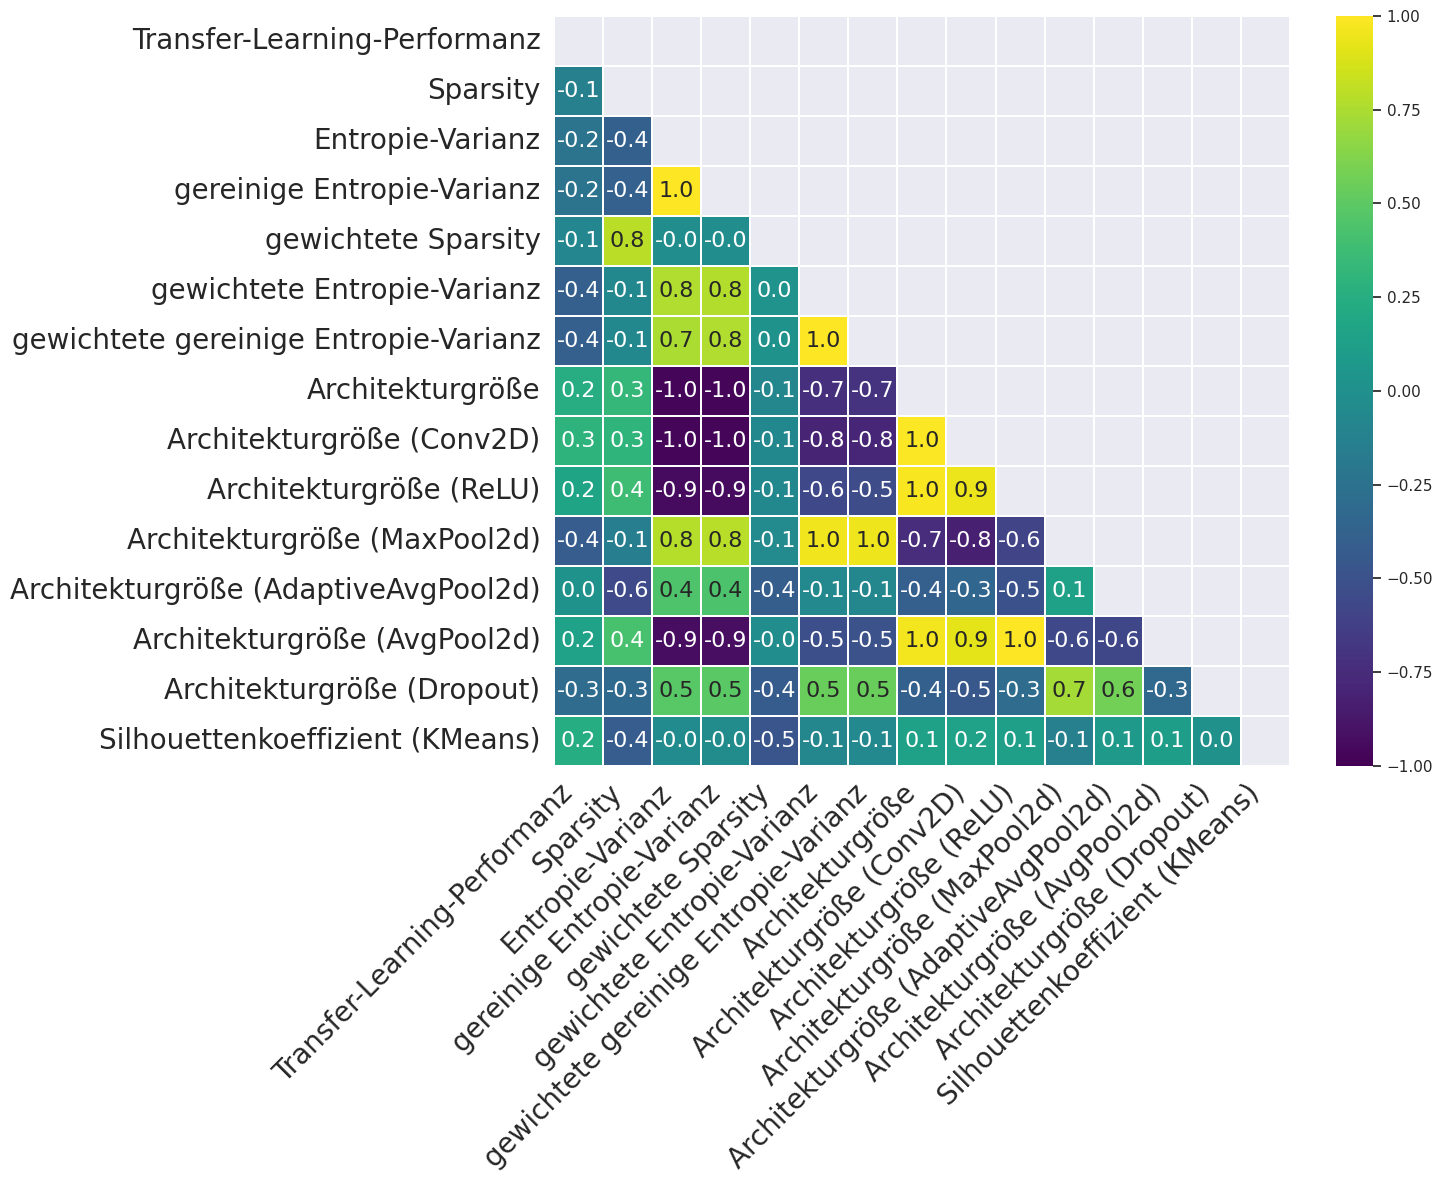

In [27]:
df_corr = hyperparameters[8][1]

features_c = [
        'difference',
        'sparsity',
        'variance_entropy',
        'variance_entropy_clean',
        'weighted_sparsity',
        'weighted_variance_entropy',
        'weighted_variance_entropy_clean',    
        'architecture_size',
        'architecture_size_Conv2d',
        'architecture_size_ReLU',
        'architecture_size_MaxPool2d',   
        'architecture_size_AdaptiveAvgPool2d',
        'architecture_size_AvgPool2d',
        'architecture_size_Dropout', 
        'latent_space_silhouette_score'
         ] 

labels = [
    'Transfer-Learning-Performanz',
    'Sparsity',
    'Entropie-Varianz',
    'gereinige Entropie-Varianz',
    'gewichtete Sparsity',
    'gewichtete Entropie-Varianz',
    'gewichtete gereinige Entropie-Varianz',
    'Architekturgröße',
    'Architekturgröße (Conv2D)',
    'Architekturgröße (ReLU)',
    'Architekturgröße (MaxPool2d)',
    'Architekturgröße (AdaptiveAvgPool2d)',
    'Architekturgröße (AvgPool2d)',
    'Architekturgröße (Dropout)',
    'Silhouettenkoeffizient (KMeans)'
]

fig, ax = plt.subplots(figsize=(15,12))

df_cm = df_corr.rename(columns=dict(zip(features_c,labels)))

sns.set(font_scale=1)
sns.heatmap(df_cm[labels].corr(),mask=np.triu(np.ones_like(df_cm[labels].corr(), dtype=bool)), vmin=-1, vmax=1, cmap="viridis", annot=True, linewidth=.1, fmt='.1f',ax=ax,annot_kws={'fontsize': 16})
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=20)
ax.set_yticklabels(ax.get_yticklabels() , fontsize=20)



fig.tight_layout()
fig.savefig("images/analysis/confusion_relation.png",dpi=300)
fig.show()

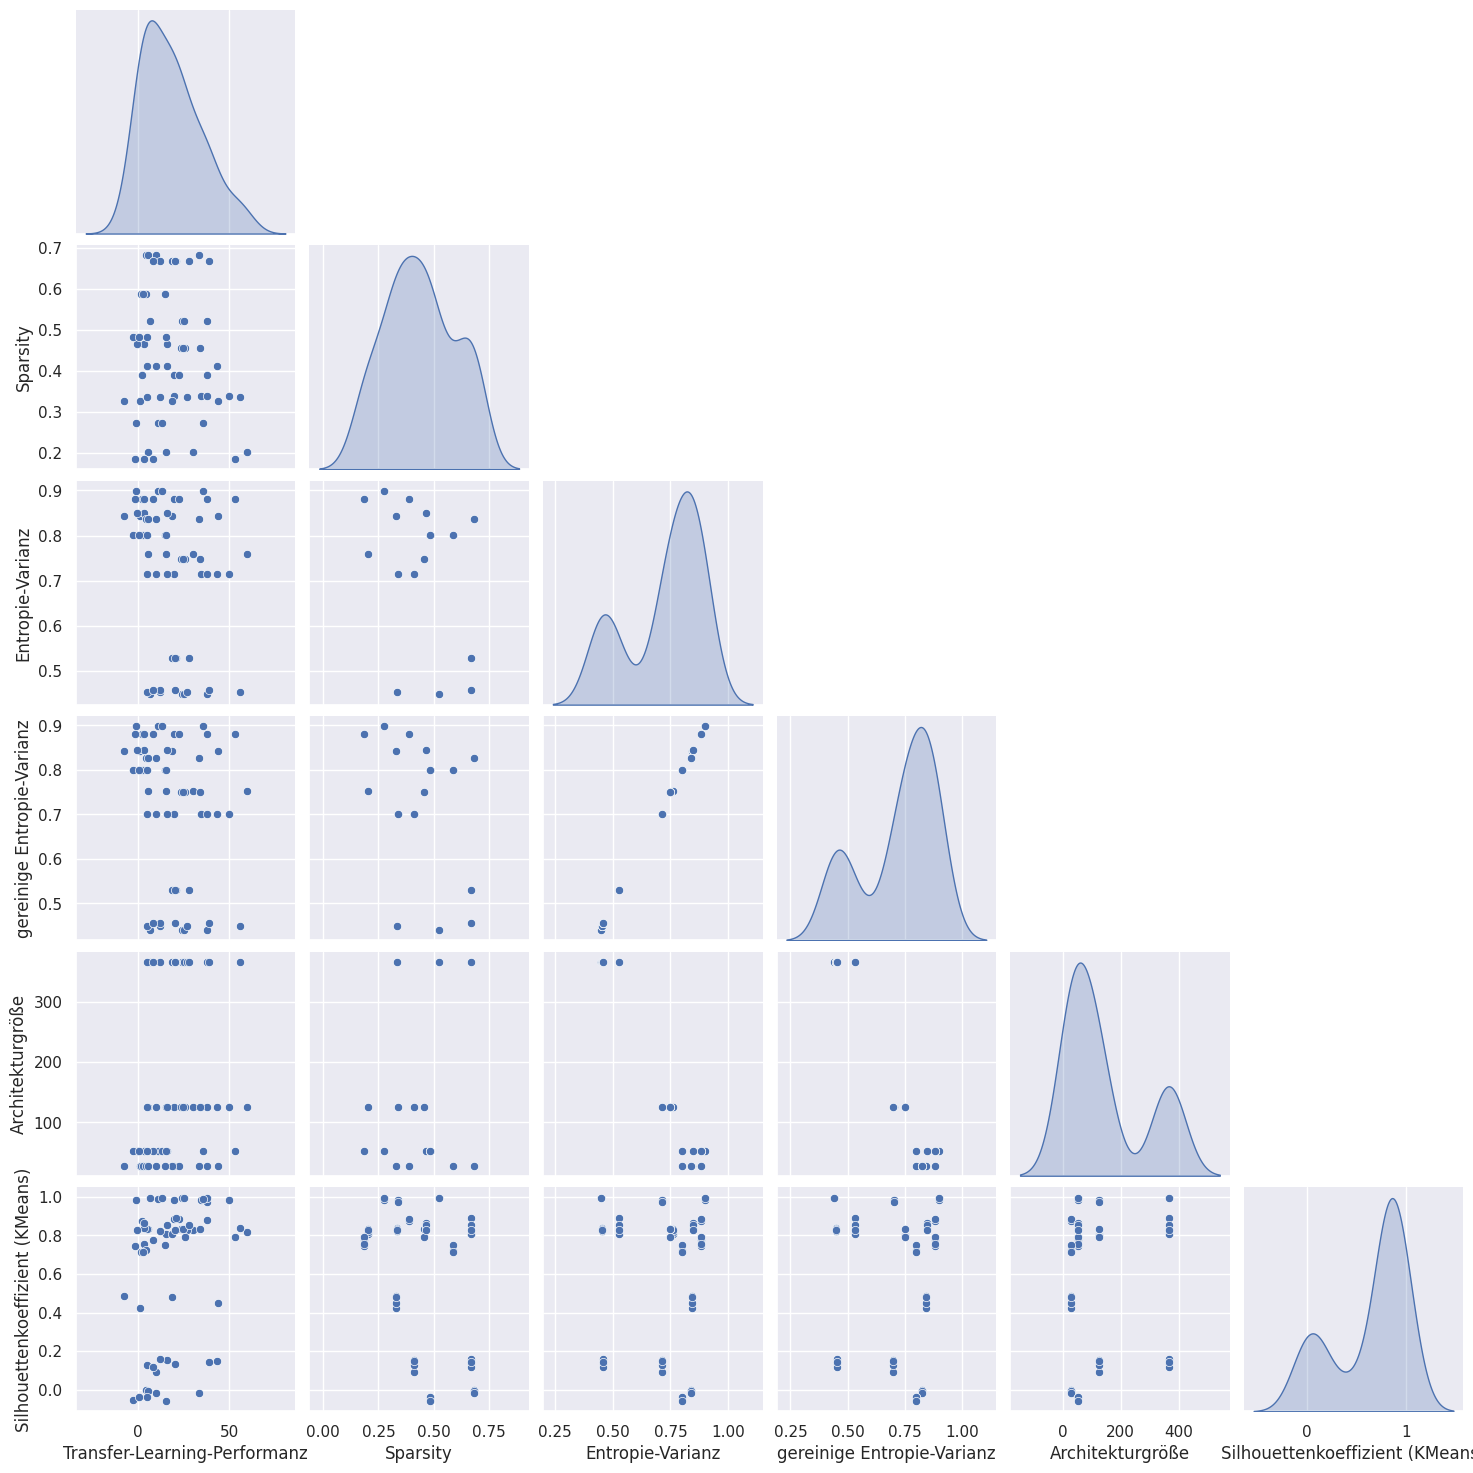

In [21]:
features_c = [
        'difference',
        'sparsity',
        'variance_entropy',
        'variance_entropy_clean',
        # 'weighted_sparsity',
        # 'weighted_variance_entropy',
        # 'weighted_variance_entropy_clean',    
        'architecture_size',
        # 'architecture_size_Conv2d',
        # 'architecture_size_ReLU',
        # 'architecture_size_MaxPool2d',   
        # 'architecture_size_AdaptiveAvgPool2d',
        # 'architecture_size_AvgPool2d',
        # 'architecture_size_Dropout', 
        'latent_space_silhouette_score'
         ] 

labels = [
    'Transfer-Learning-Performanz',
    'Sparsity',
    'Entropie-Varianz',
    'gereinige Entropie-Varianz',
    # 'gewichtete Sparsity',
    # 'gewichtete Entropie-Varianz',
    # 'gewichtete gereinige Entropie-Varianz',
    'Architekturgröße',
    # 'Architekturgröße (Conv2D)',
    # 'Architekturgröße (ReLU)',
    # 'Architekturgröße (MaxPool2d)',
    # 'Architekturgröße (AdaptiveAvgPool2d)',
    # 'Architekturgröße (AvgPool2d)',
    # 'Architekturgröße (Dropout)',
    'Silhouettenkoeffizient (KMeans)'
]



df_cm = df_corr.rename(columns=dict(zip(features_c,labels)))

g = sns.pairplot(df_cm[labels], diag_kind="kde", corner=True, )

# g.map_lower(sns.kdeplot, levels=4, color=".2")
fig = g.fig
# plt.xlabel('', fontsize=16);
# plt.ylabel('', fontsize=16);
fig.savefig("images/analysis/relation_scatter.png", dpi=300)

In [22]:
import multiprocessing as mp
import random
import time



class RandomPipeline:
    def __init__(self):        
        random.seed(str(RandomForestPipeline([]))+str(time.time()))    

    class _random_predict:
        def __init__(self, len_):
            self.len_ = len_
            
        def __call__(self, x):
            return [random.uniform(-1,1) * 100 for x in range(self.len_)]
        
        
    def predict(self, X):           
        return self._random_predict(len(X))(0)

In [23]:
random_pipeline = RandomPipeline()

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def get_dataset(X_batches, finetune_dataset_name, split):
    if split == "train":
        return {"X":X_batches[finetune_dataset_name][1], "y":X_batches[finetune_dataset_name][4]}
    if split == "test":
        return {"X":X_batches[finetune_dataset_name][2], "y":X_batches[finetune_dataset_name][5]}
    if split == "all":
        return {"X":X_batches[finetune_dataset_name][0], "y":X_batches[finetune_dataset_name][3]}
    return {}

def get_ranking_error(all_dfs): 
    def get_error(datasets, c=1):
        if type(datasets) == str:
            datasets=[datasets]
        errors=[]
        for dataset in datasets:
            predicted_real=np.array(all_dfs[dataset].sort_values(by="difference_predict", ascending=False)['difference'])
            real=np.array(all_dfs[dataset].sort_values(by="difference", ascending=False)['difference'])
            # print(predicted_real-real)
            errors.append((predicted_real-real)[:c])
        return np.array(errors).mean()
    return get_error

In [25]:
class Evaluation:
    
    def __init__(self, X_batches,df,regr_pipeline, split, finetune_datasets):
        self.split = split
        self.X_batches = X_batches
        self.regr_pipeline = regr_pipeline
        self.df = df
        
        self.all_predict_dfs = {}
        self.all_random_dfs = {}    
        
        self.finetune_datasets = finetune_datasets
        self.random_pipeline = RandomPipeline()
        
        self.__init_dfs()
        
    def __init_dfs(self):
        for dataset in self.finetune_datasets:
            self.all_predict_dfs[dataset]=calculate_predict_diff(self.regr_pipeline, self.df, **get_dataset(self.X_batches,dataset,self.split))
            self.all_random_dfs[dataset]=calculate_predict_diff(self.random_pipeline, self.df, **get_dataset(self.X_batches,dataset,self.split))
    
    
    def ranking_error(self, c=1):
        return get_ranking_error(self.all_predict_dfs)(self.finetune_datasets,c=c)
    
    def get_metrics(self):
#         y_true = y_train
#         y_pred = self.regr_pipeline.predict(X_train)

#         print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_true, y_pred))
#         print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_true, y_pred))
#         print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(y_true, y_pred, squared=False))
#         print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(y_true, y_pred))
#         print('Explained Variance Score:', metrics.explained_variance_score(y_true, y_pred))
#         print('Max Error:', metrics.max_error(y_true, y_pred))
#         print('Mean Squared Log Error:', metrics.mean_squared_log_error(y_true, y_pred))
#         print('Median Absolute Error:', metrics.median_absolute_error(y_true, y_pred))
#         print('R^2:', metrics.r2_score(y_true, y_pred))
#         print('Mean Poisson Deviance:', metrics.mean_poisson_deviance(y_true, y_pred))
#         print('Mean Gamma Deviance:', metrics.mean_gamma_deviance(y_true, y_pred))
#         metrics={}
#         metrics['r2_value']=self.regr_pipeline
        pass

    def plot_importances(self, figsize=(10,10)):
        
        X_all,y_all = [],[]
        for dataset in self.finetune_datasets:
            X_temp = get_dataset(self.X_batches,dataset,self.split)['X']
            y_temp = get_dataset(self.X_batches,dataset,self.split)['y']
            for values in X_temp:        
                X_all.append(values)
            for values in y_temp:
                y_all.append(values)            
            
        return self.regr_pipeline.plot_importances(np.array(X_all),np.array(y_all))
        
    
    def plot(self, figsize=(10,10)):
        cols = 2
        rows = int(np.ceil(len(self.finetune_datasets)/2))

        finetune_datasets_reshape=[]

        temp=[]
        for idx, dataset in enumerate(self.finetune_datasets):
            temp.append(dataset)
            if (idx+1) % (cols) == 0:
                finetune_datasets_reshape.append(temp)
                temp=[]


        # print(finetune_datasets_reshape)


        fig, ax = plt.subplots(cols,rows,figsize=figsize)

        for col in range(cols):
            for row in range(rows):
                # print()
                self.all_predict_dfs[finetune_datasets_reshape[row][col]].sort_values(by="difference_predict", ascending=False)[['finetune_dataset','pretrained_dataset','model','difference_predict']].set_index(['finetune_dataset','pretrained_dataset','model']).plot.bar(ax=ax[row,col], rot=90)
                self.all_predict_dfs[finetune_datasets_reshape[row][col]].sort_values(by="difference_predict", ascending=False)[['finetune_dataset','pretrained_dataset','model','difference']].set_index(['finetune_dataset','pretrained_dataset','model']).plot(ax=ax[row,col], rot=90,color="red")
                # ax[row,col].set_xlabel(all_predict_dfs[finetune_datasets_reshape[row][col]])
                ax[row,col].set_title(f"Finetuned on {finetune_datasets_reshape[row][col]}")
                # ax[row,col].set_xlabel(ax[row,col].get_xlabel(),rotation=45)
        fig.tight_layout()
        return fig

In [26]:
eval_static = Evaluation(X_batches_static,df_static,regr_pipeline_static, "test", finetune_datasets)

In [27]:
eval_static.ranking_error()

-14.368992567062374

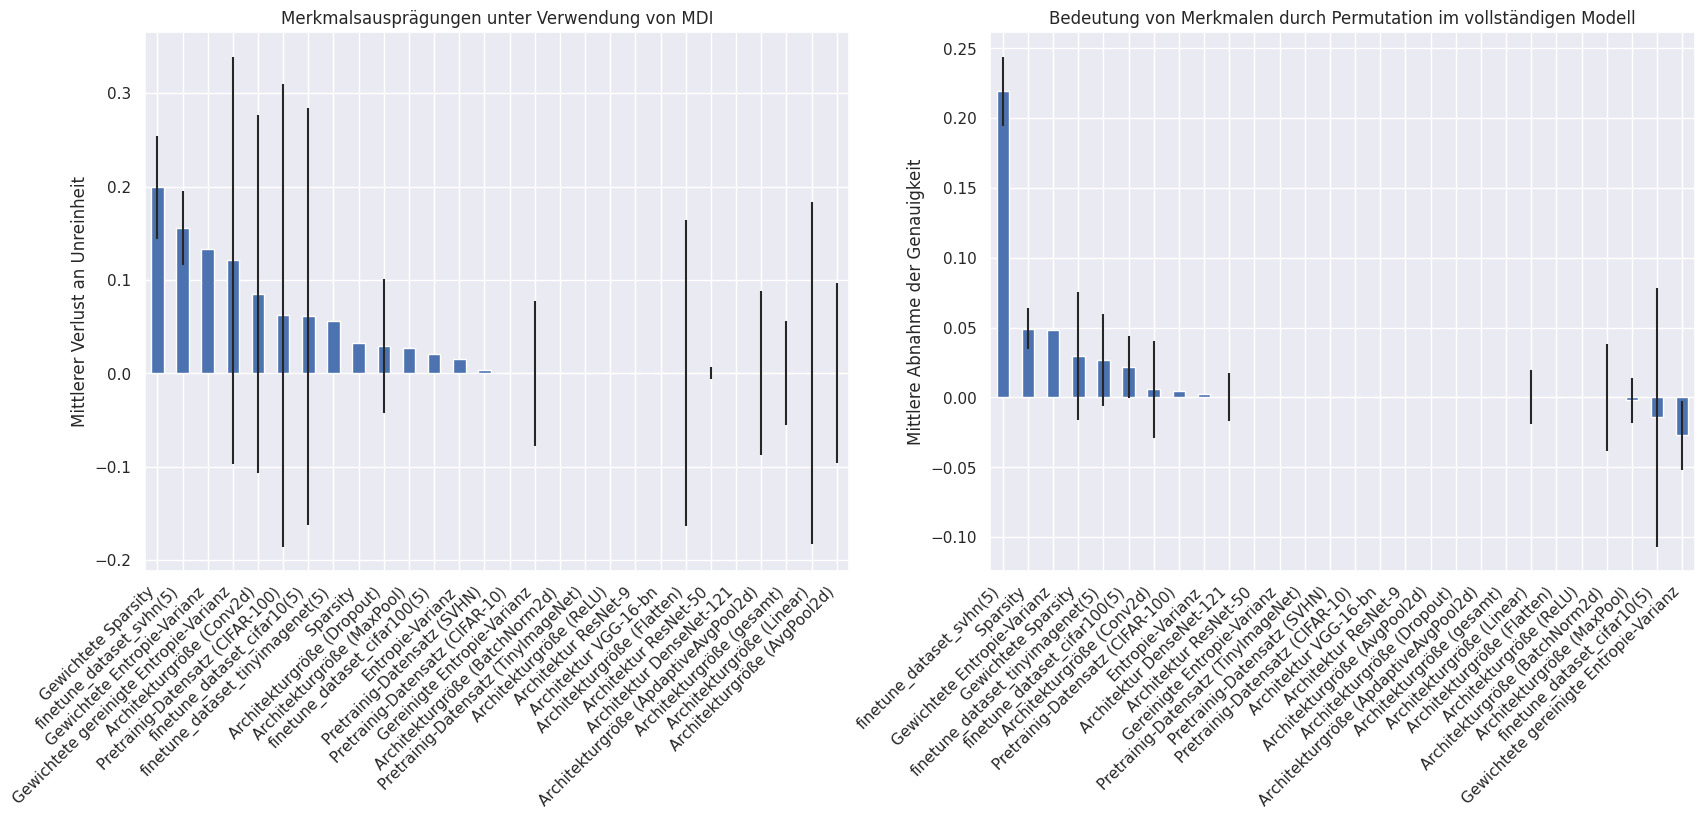

In [28]:
fig=eval_static.plot_importances()
fig.show()

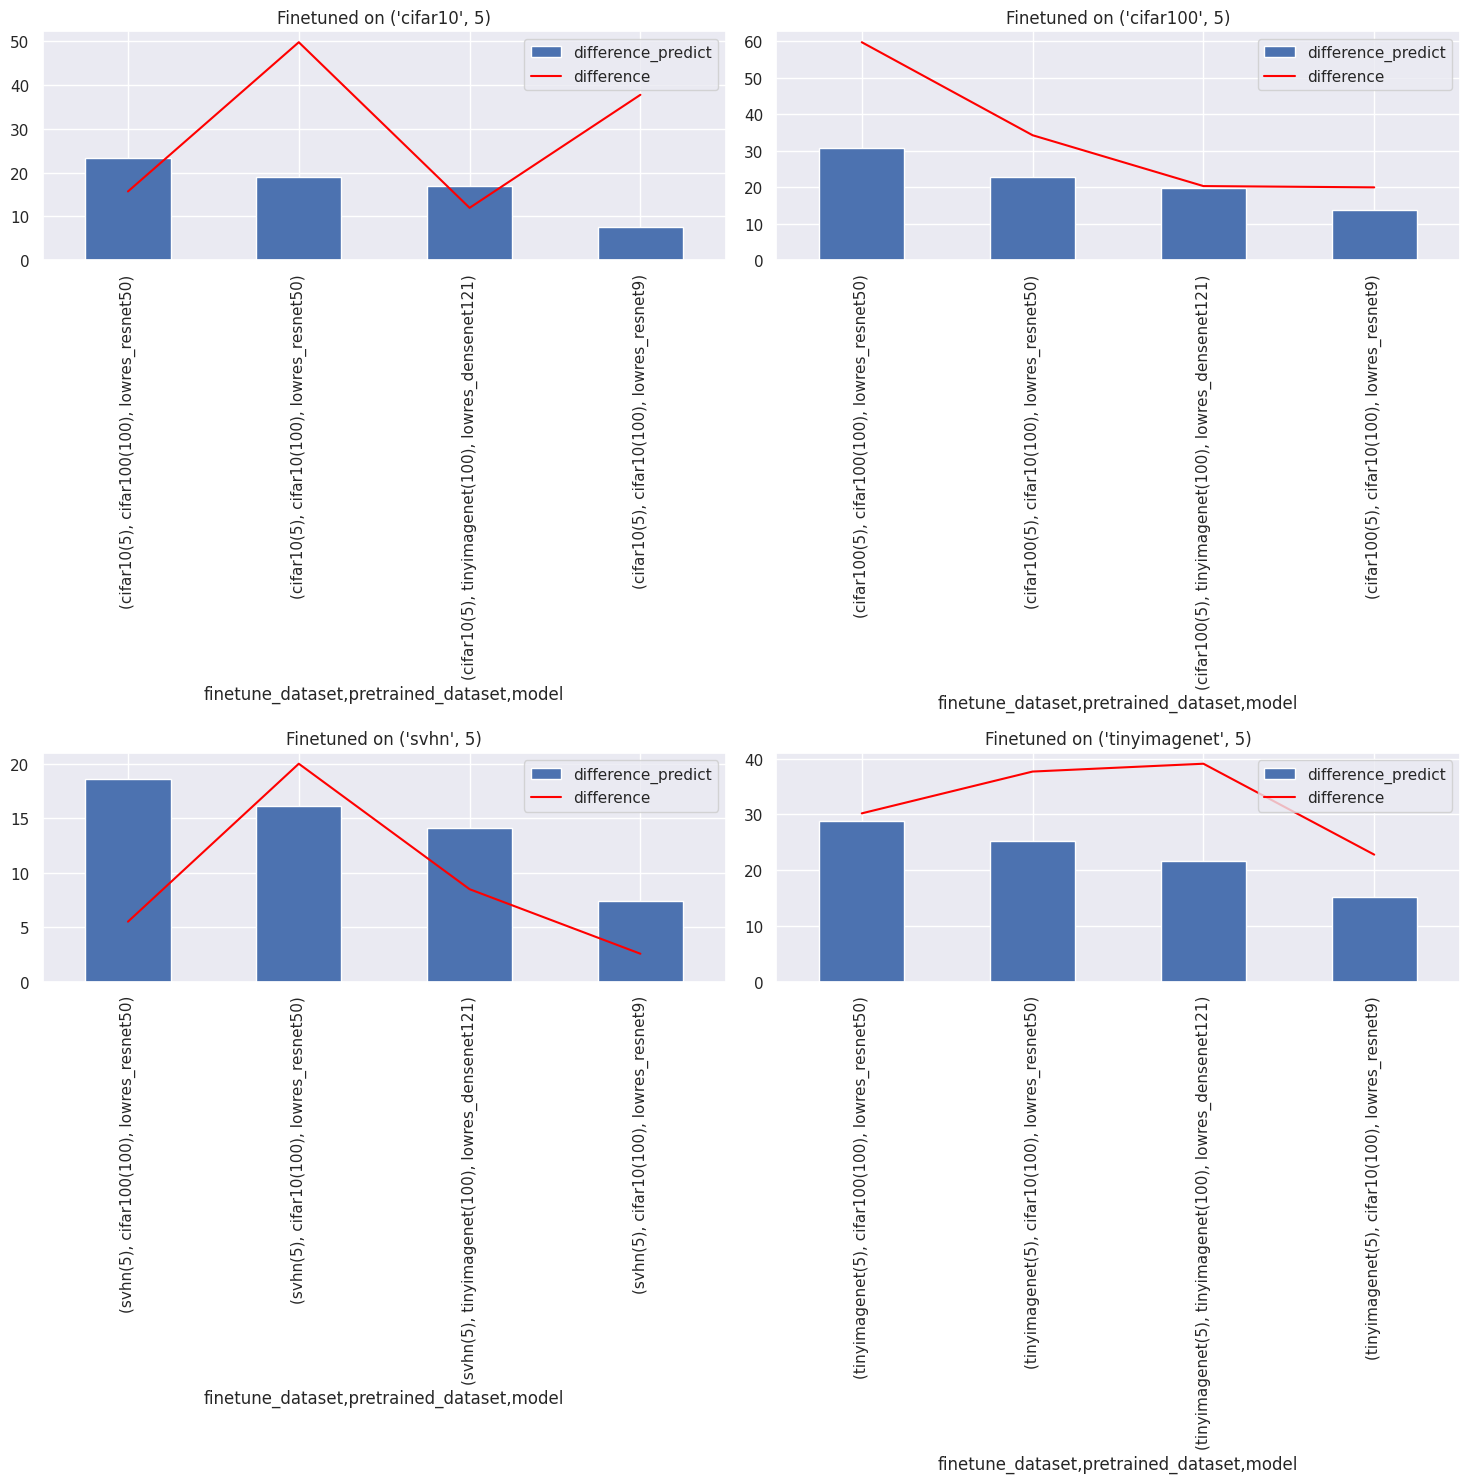

In [29]:
fig=eval_static.plot(figsize=(15,15))
fig.show()

In [30]:
eval_static = Evaluation(X_batches_static,df_static,regr_pipeline_static, "train", finetune_datasets)

In [31]:
eval_static.ranking_error()

-17.608384788036346

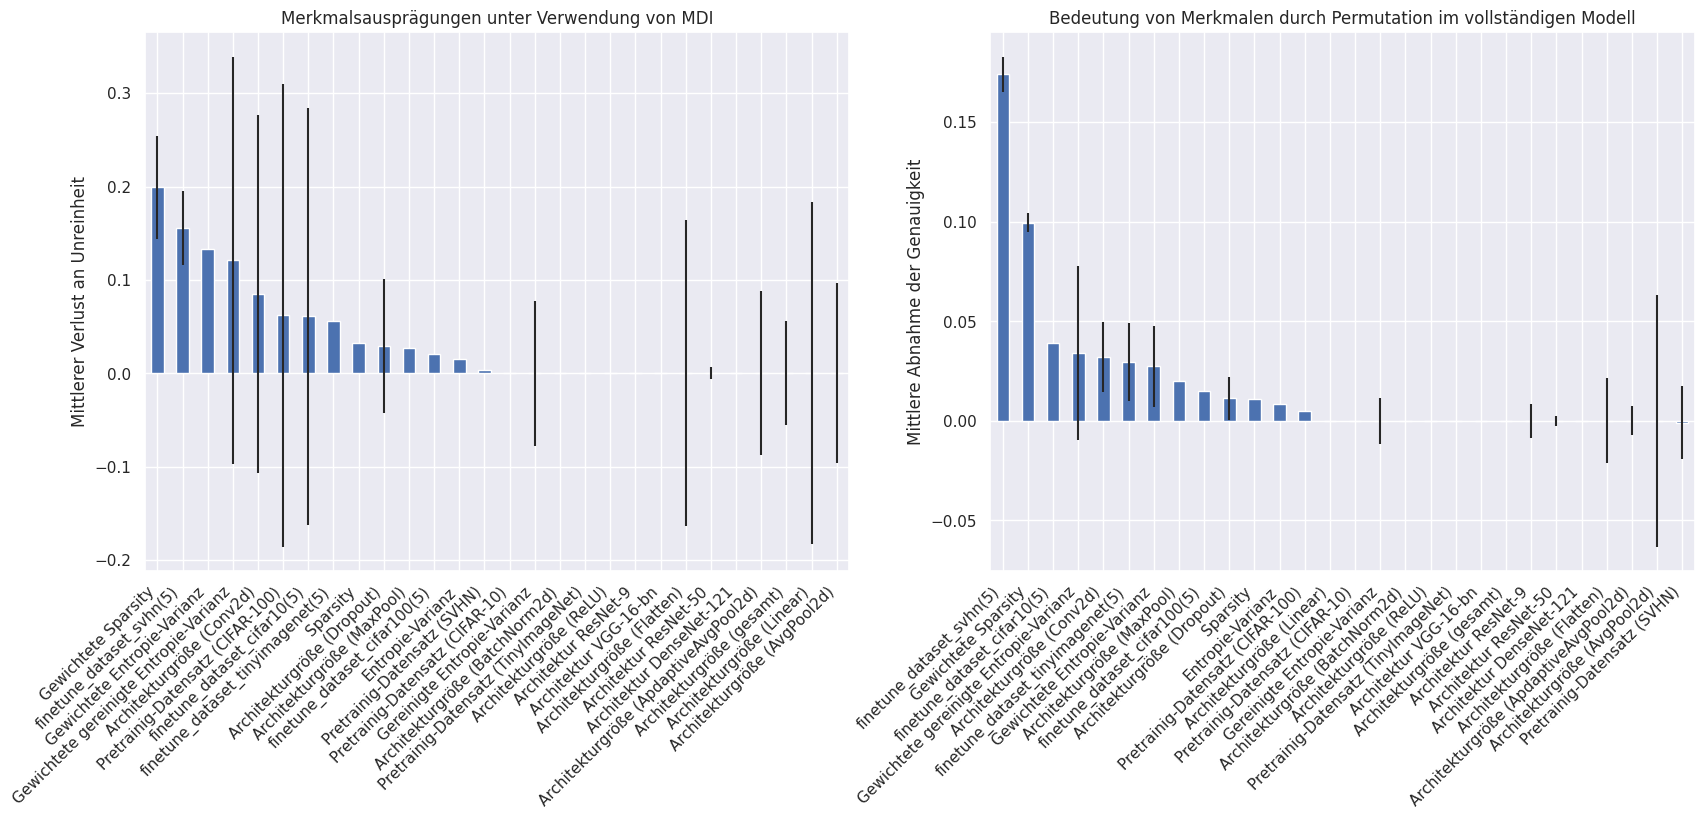

In [32]:
fig=eval_static.plot_importances()
fig.show()

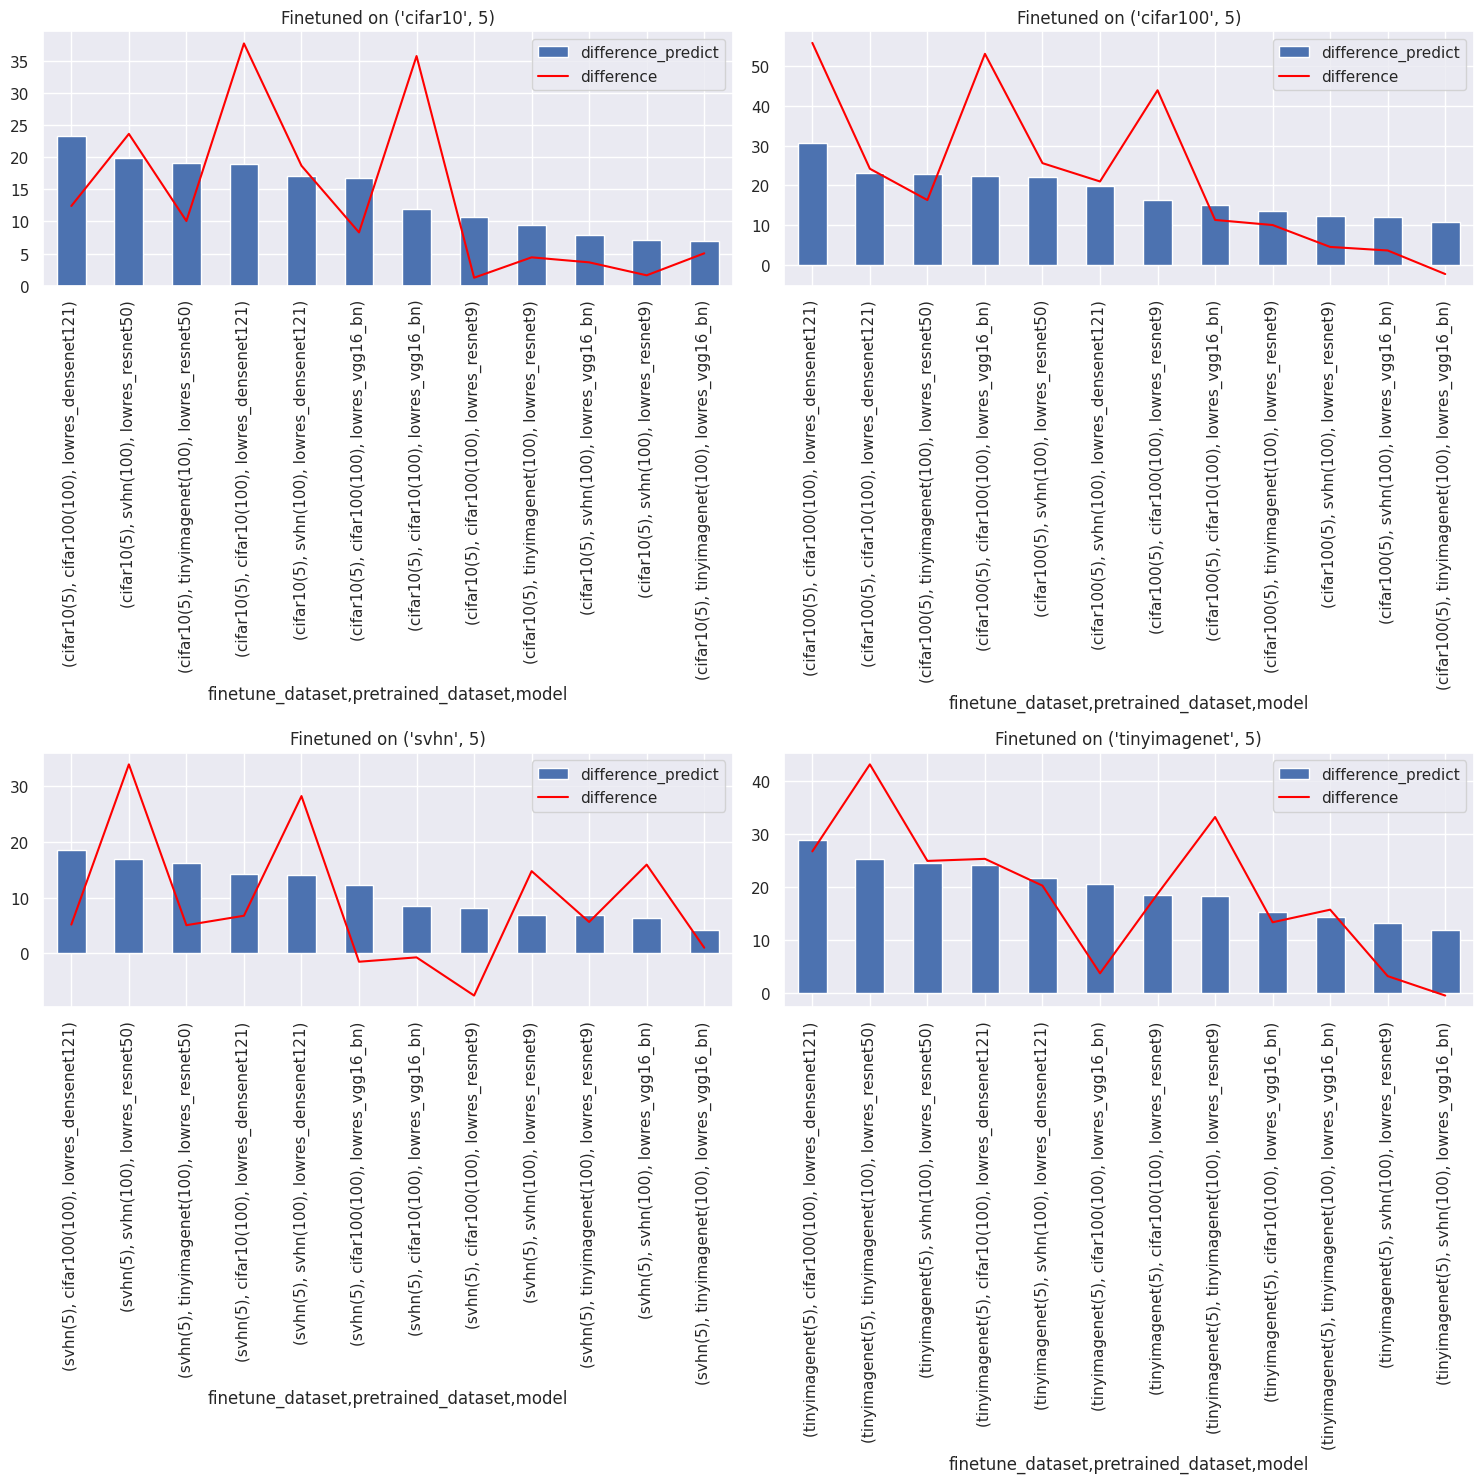

In [33]:
fig=eval_static.plot(figsize=(15,15))
fig.show()

In [34]:
eval_dynamic = Evaluation(X_batches_dynamic,df_dynamic,regr_pipeline_dynamic, "test", finetune_datasets)

In [35]:
eval_dynamic.ranking_error()

-23.487292051315304

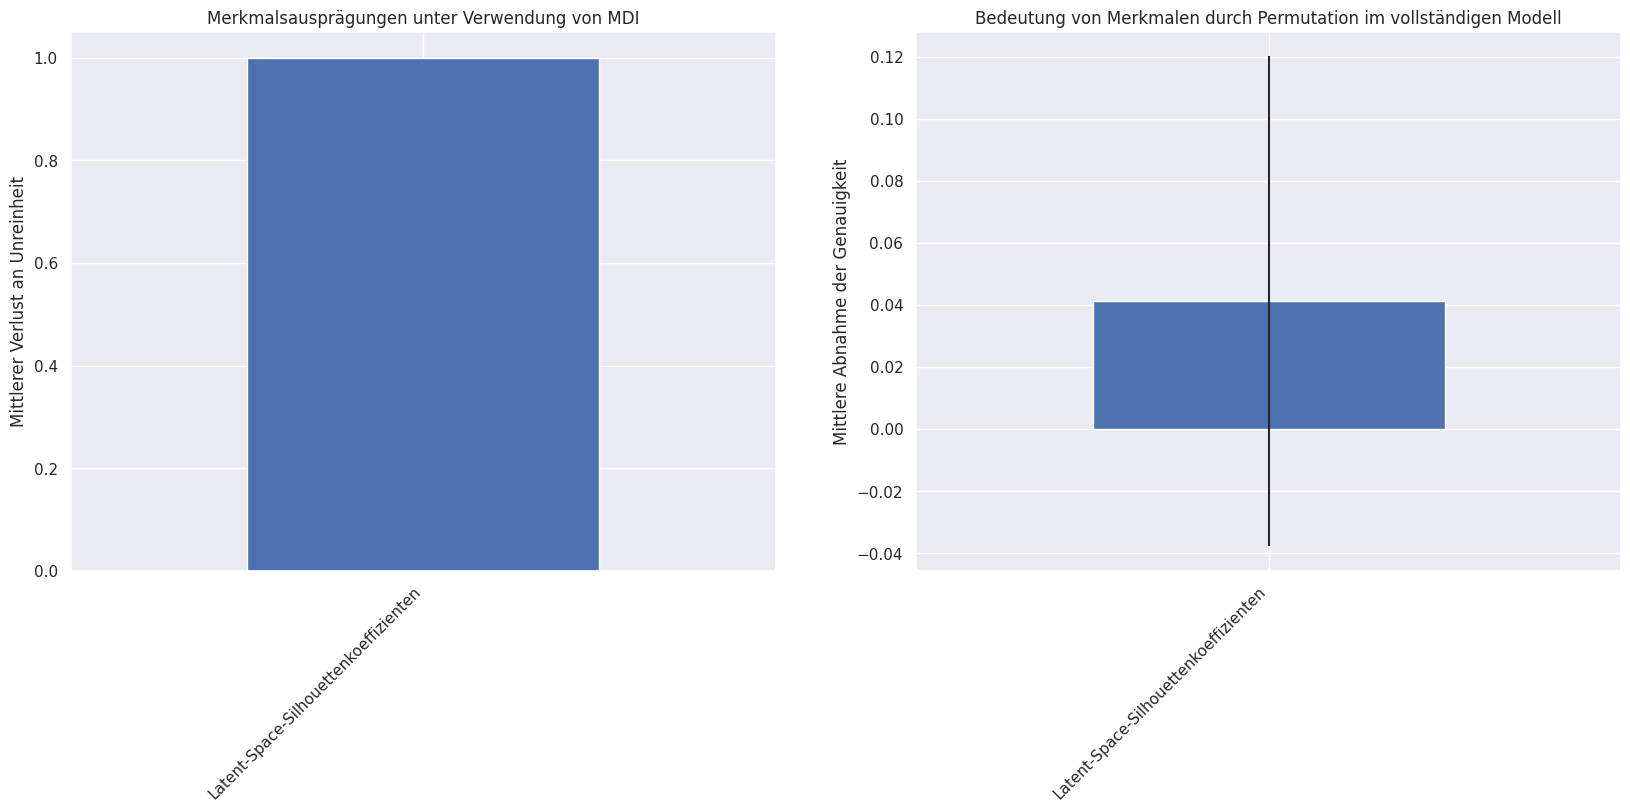

In [36]:
fig=eval_dynamic.plot_importances()
fig.show()

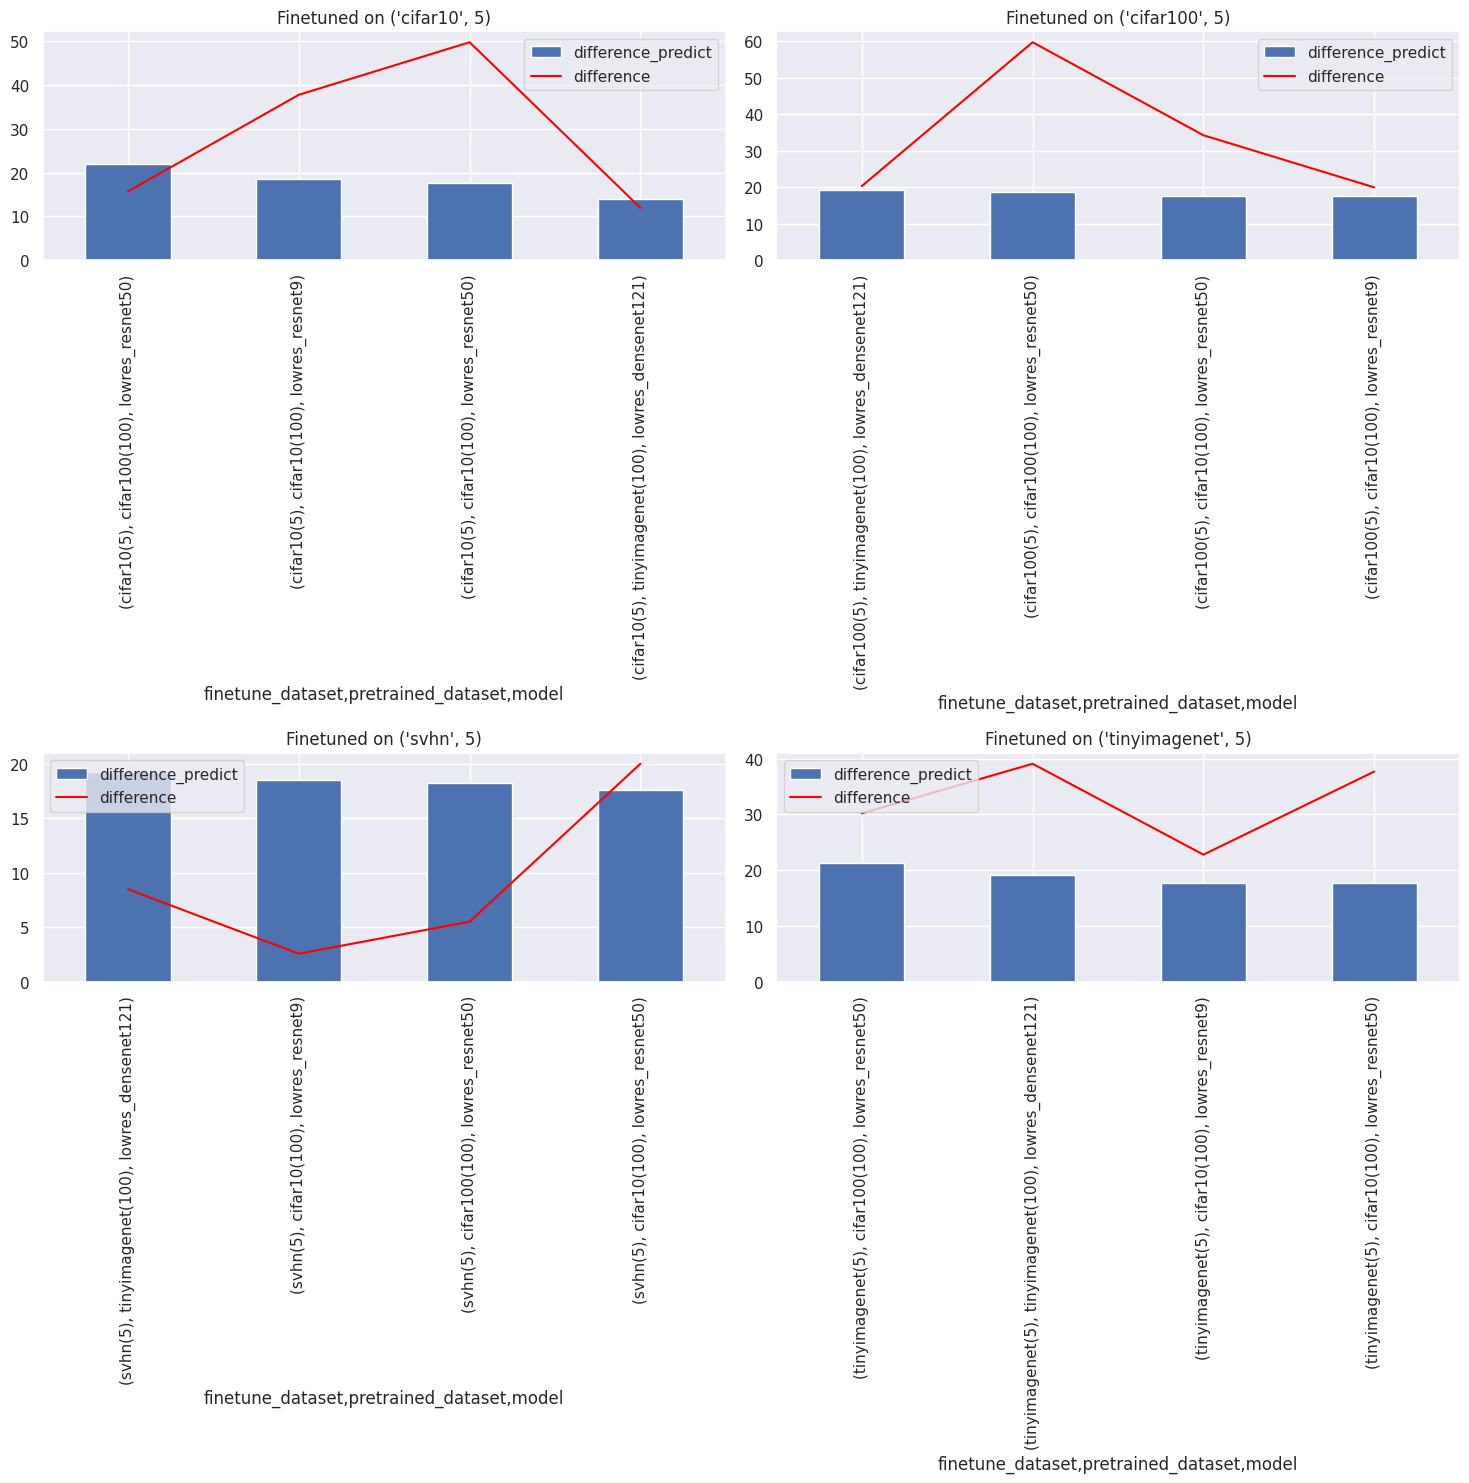

In [37]:
fig=eval_dynamic.plot(figsize=(15,15))
fig.show()

In [38]:
eval_dynamic = Evaluation(X_batches_dynamic,df_dynamic,regr_pipeline_dynamic, "train", finetune_datasets)

In [39]:
eval_dynamic.ranking_error()

-21.98575085401535

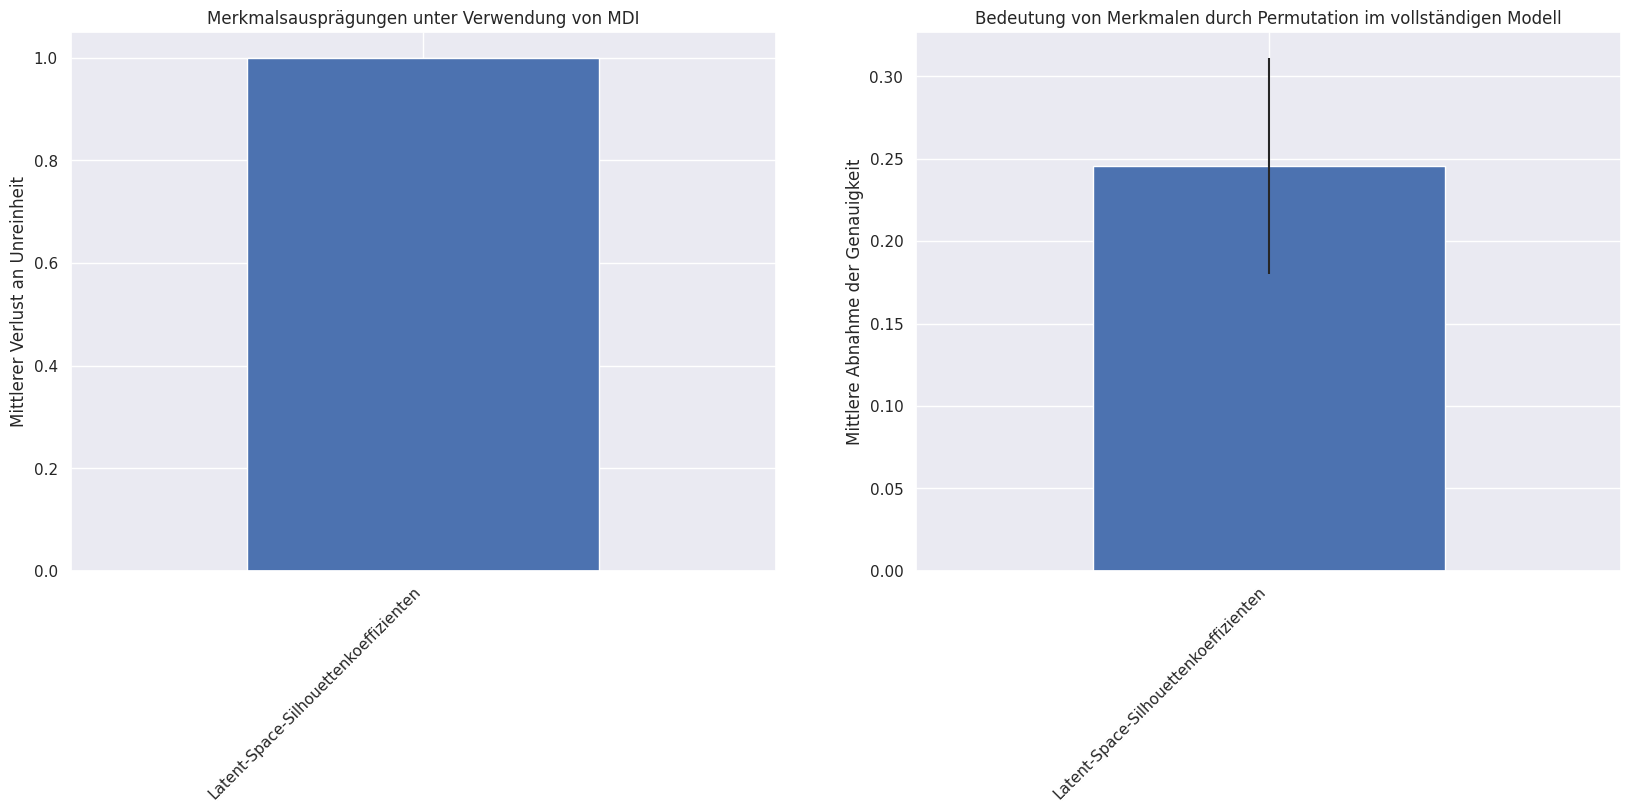

In [40]:
fig=eval_dynamic.plot_importances()
fig.show()

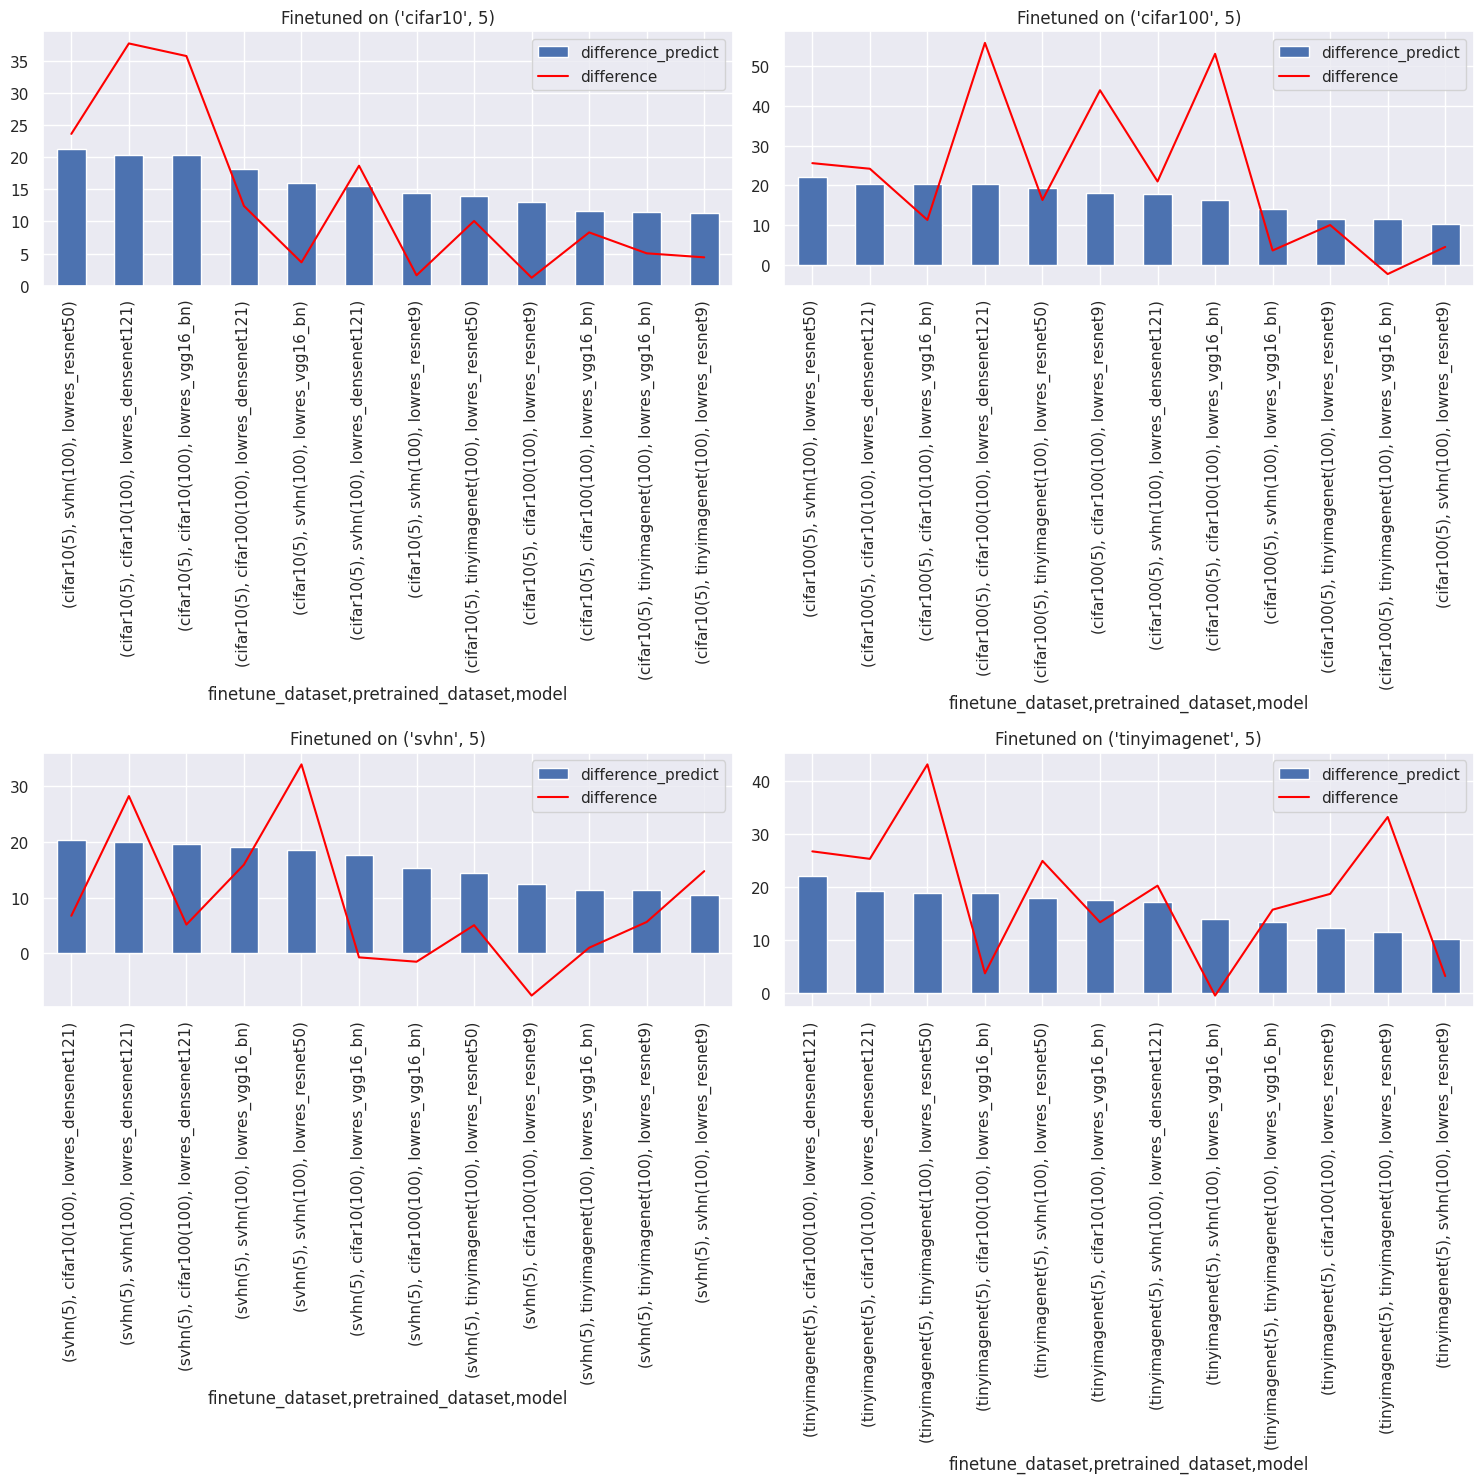

In [41]:
fig=eval_dynamic.plot(figsize=(15,15))
fig.show()

In [42]:
eval_both = Evaluation(X_batches_both,df_both,regr_pipeline_both, "test", finetune_datasets)

In [43]:
eval_both.ranking_error()

-13.08016729354858

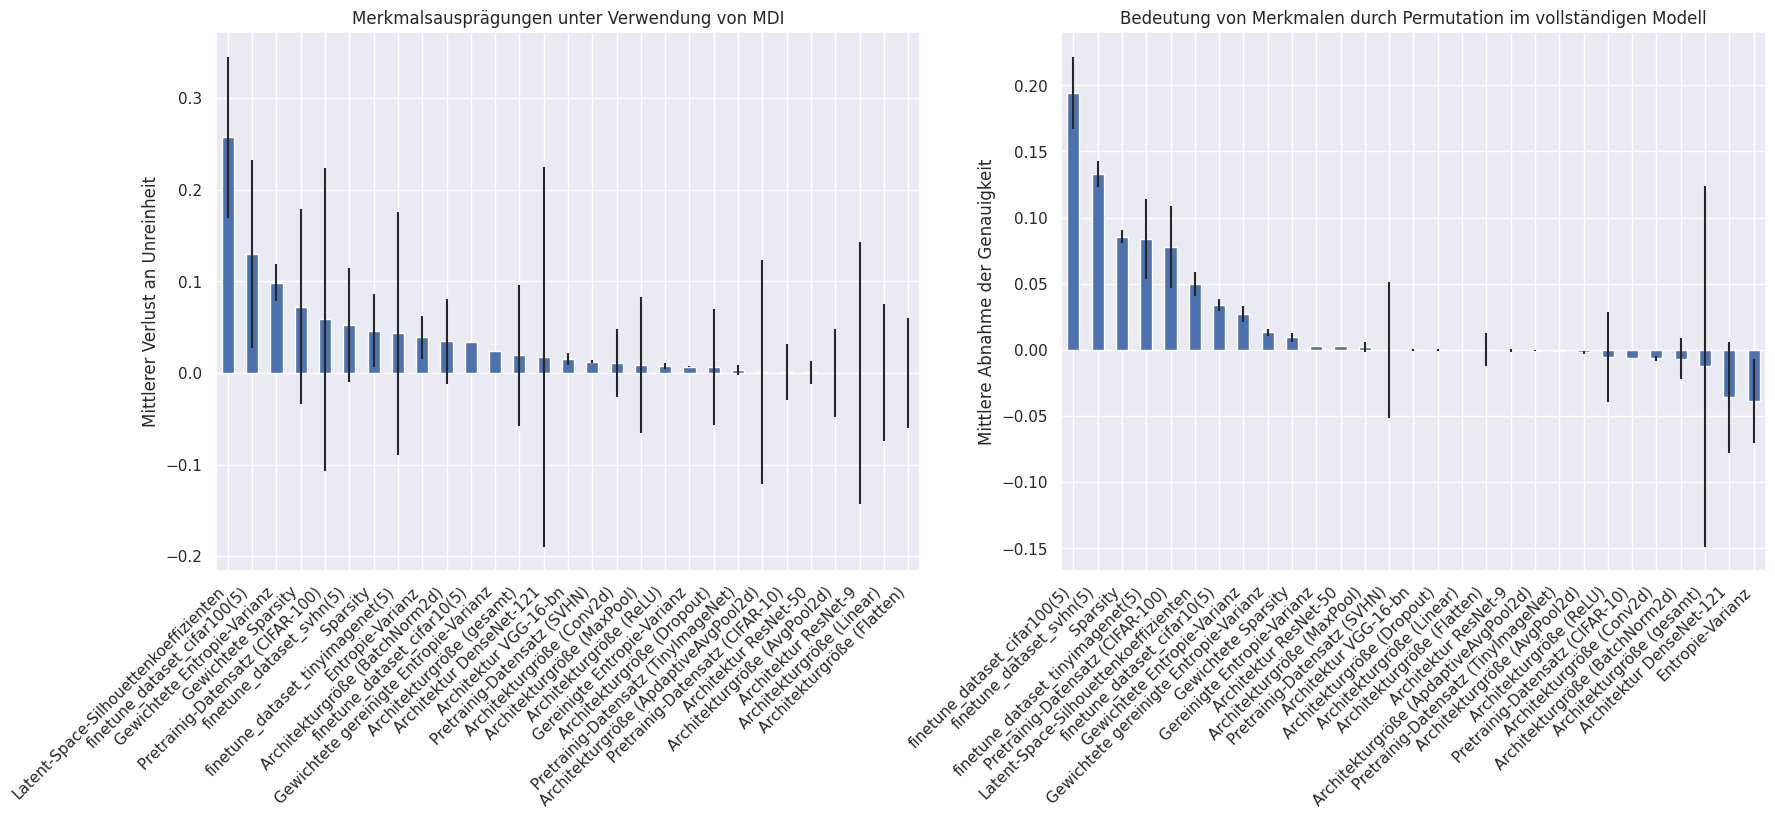

In [44]:
fig=eval_both.plot_importances()
fig.show()

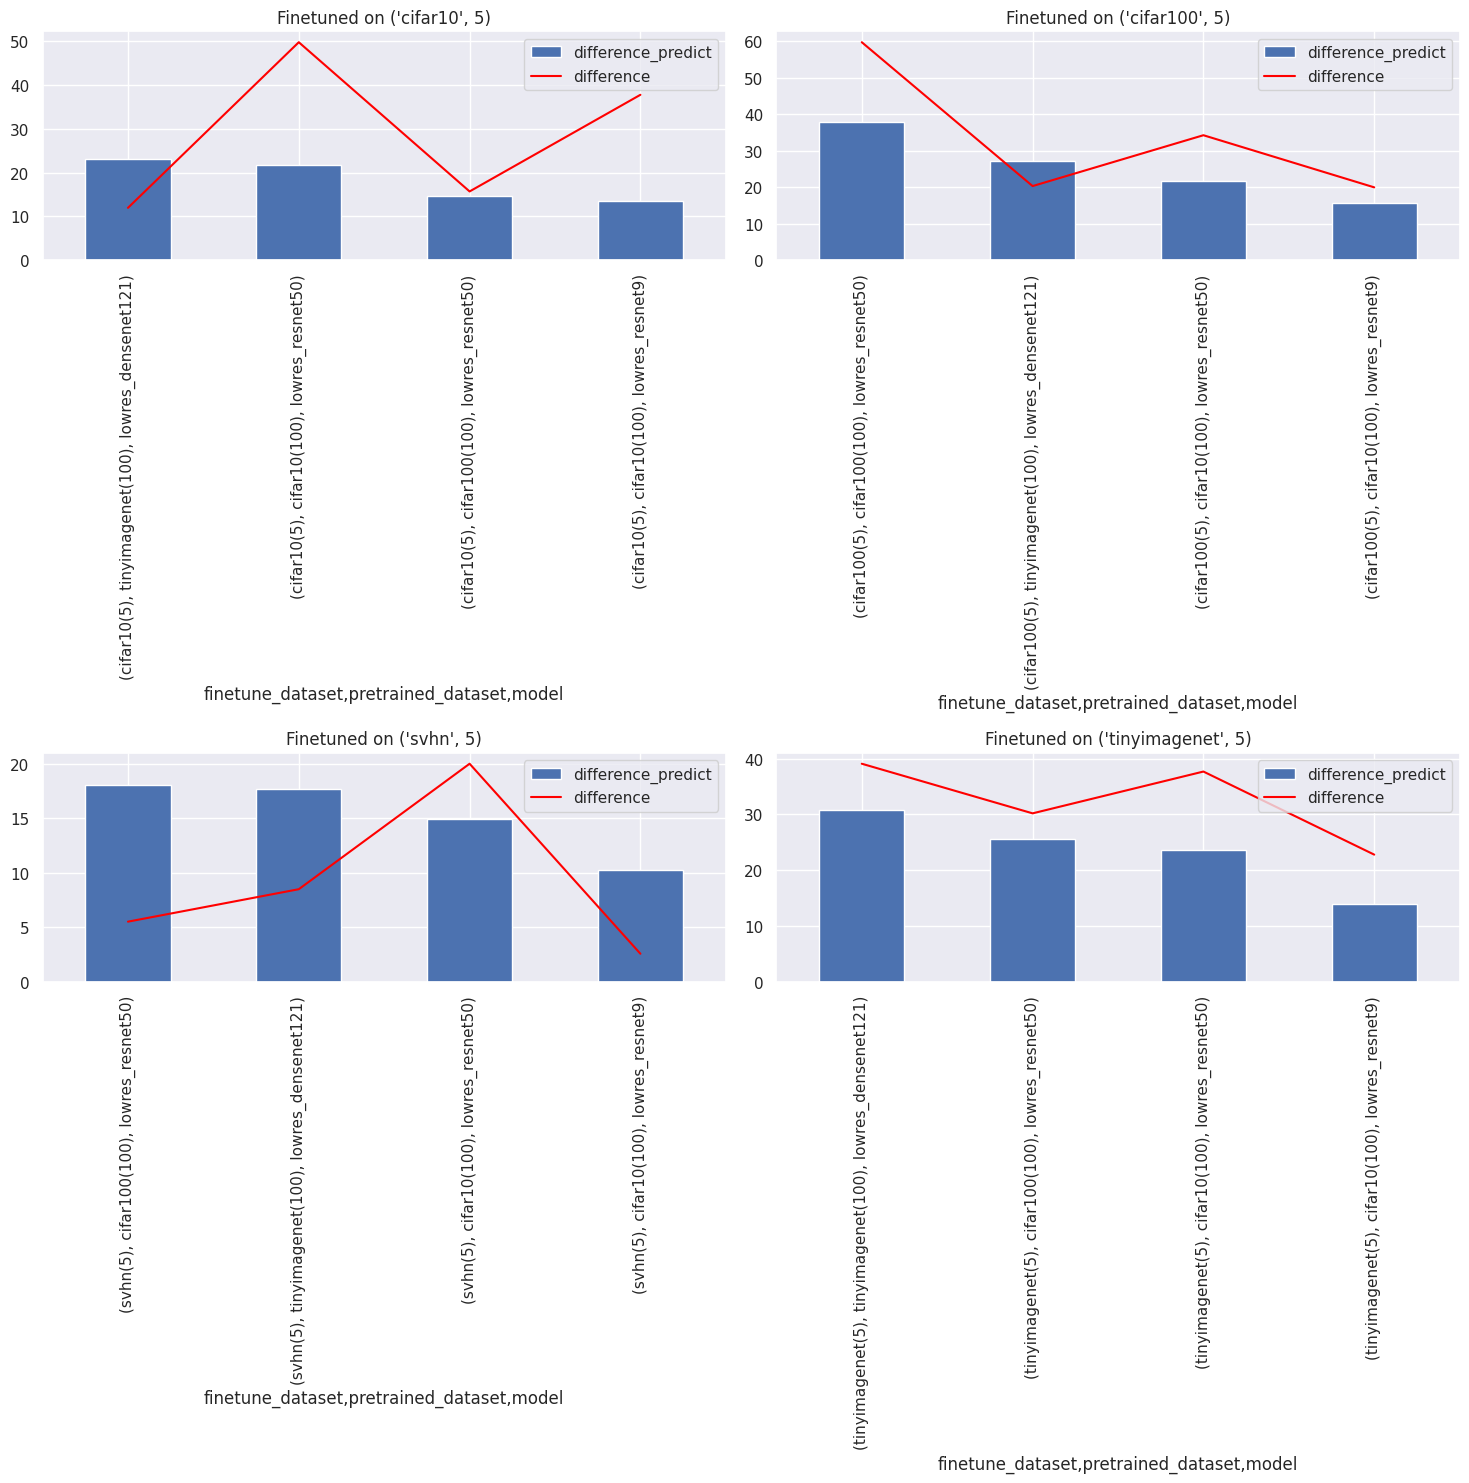

In [45]:
fig=eval_both.plot(figsize=(15,15))
fig.show()

In [46]:
eval_both = Evaluation(X_batches_both,df_both,regr_pipeline_both, "train", finetune_datasets)

In [47]:
eval_both.ranking_error()

-4.459423720836639

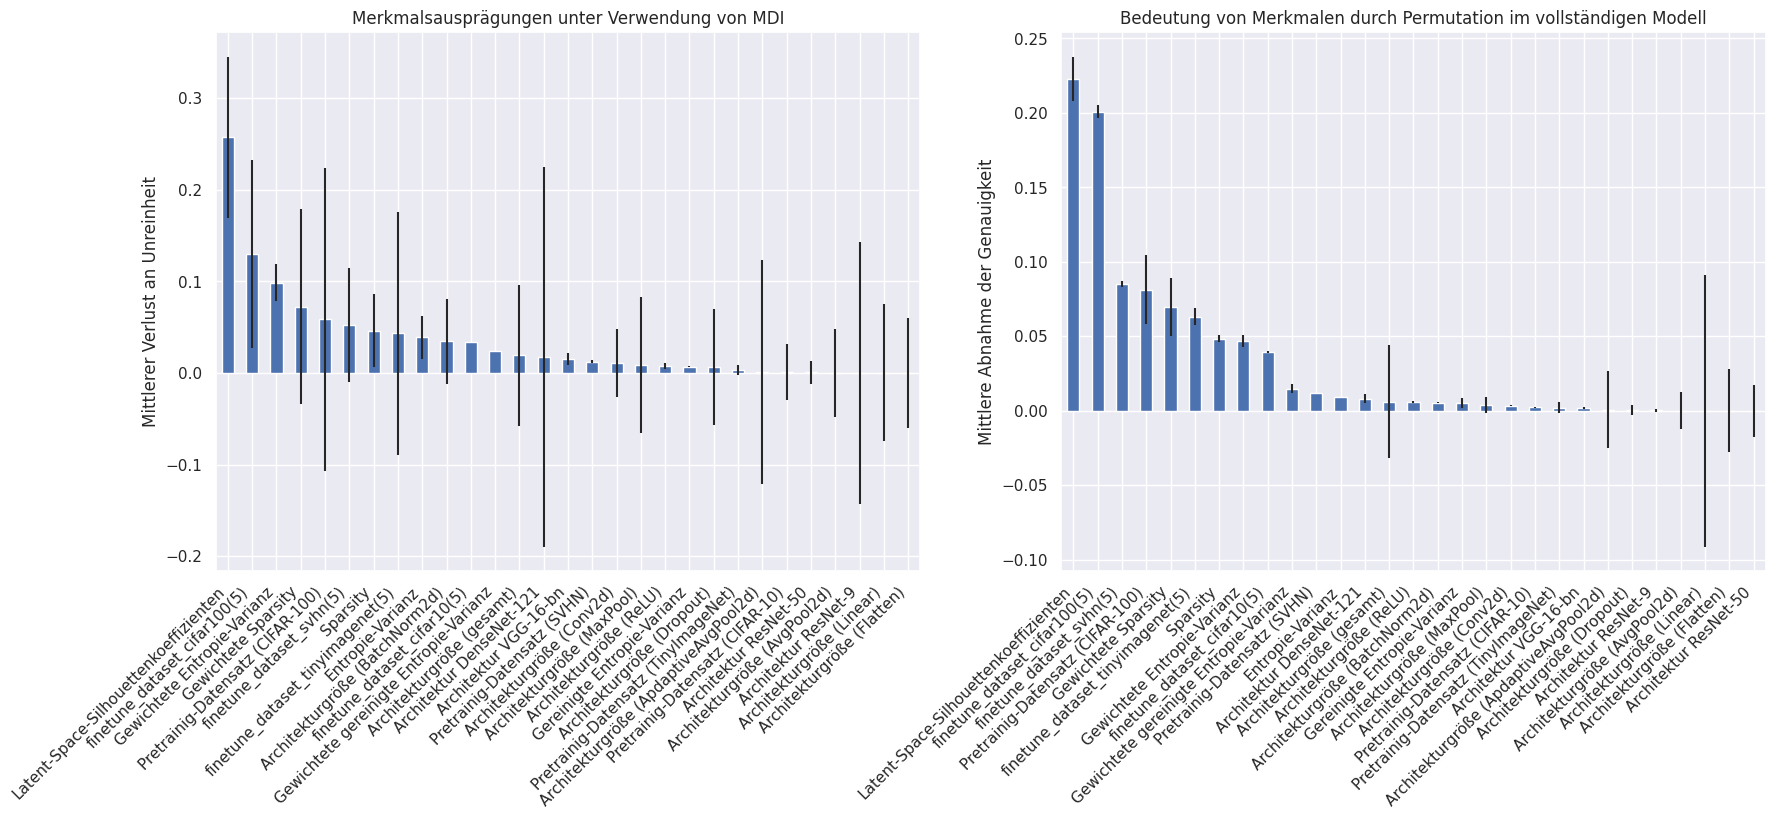

In [48]:
fig=eval_both.plot_importances()
fig.show()

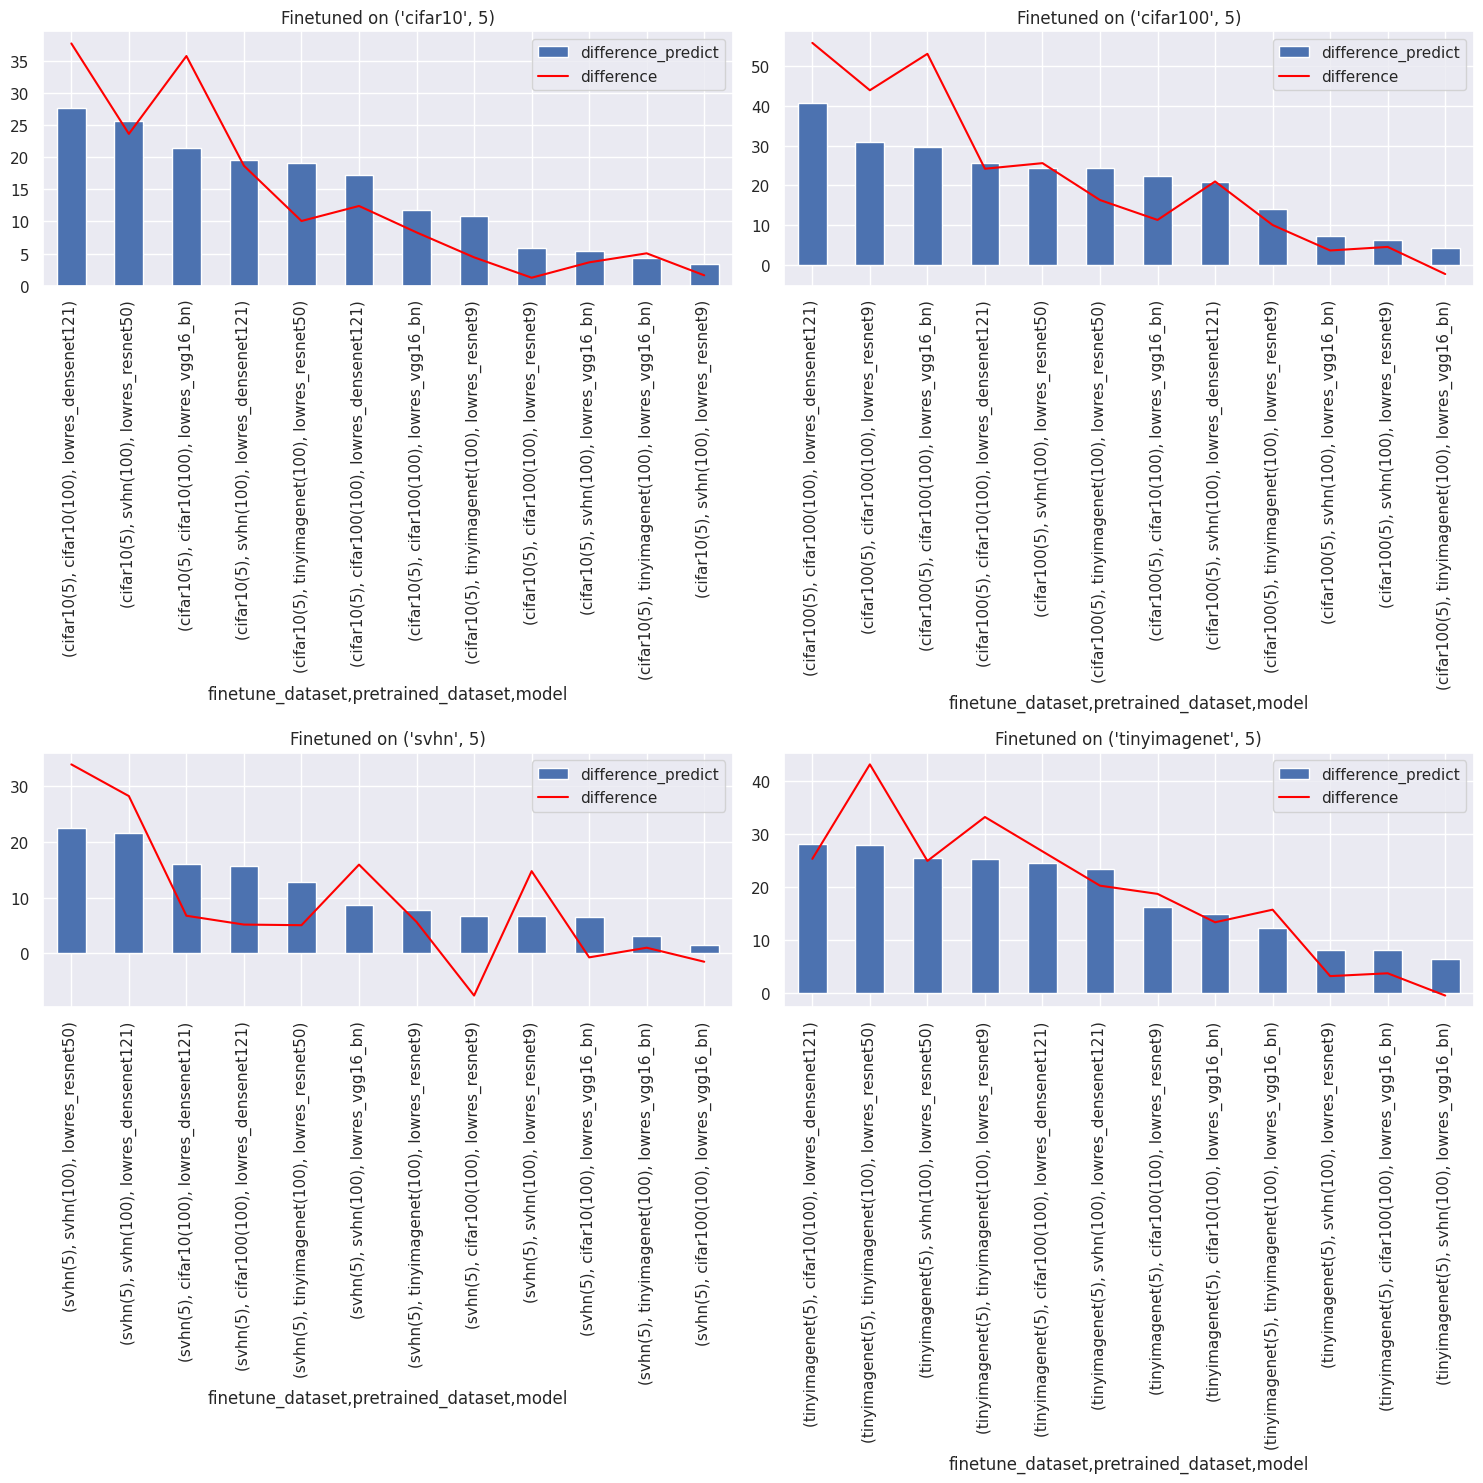

In [49]:
fig=eval_both.plot(figsize=(15,15))
fig.show()

In [50]:
os.environ['PATH'] = os.environ['PATH']+';'+os.environ['CONDA_PREFIX']+r"\Library\bin\graphviz"

In [51]:
import pydotplus
from sklearn import tree

def generate_decision_path_image(decision_regressor, dataset, split, save_path):    

    regr = decision_regressor

    X, y = get_dataset(dataset,split)['X'],get_dataset(dataset,split)['y']
    # print(X.shape)
    # return

    dot_data = tree.export_graphviz(regr, out_file=None,
                                    feature_names=features,  
                                    class_names=y,
                                    filled=True, rounded=True,
                                    special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data)

    # empty all nodes, i.e.set color to white and number of samples to zero
    for node in graph.get_node_list():
        if node.get_attributes().get('label') is None:
            continue
        if 'samples = ' in node.get_attributes()['label']:
            labels = node.get_attributes()['label'].split('<br/>')
            for i, label in enumerate(labels):
                if label.startswith('samples = '):
                    labels[i] = 'samples = 0'
            node.set('label', '<br/>'.join(labels))
            node.set_fillcolor('white')

    samples = X
    decision_paths = regr.decision_path(samples)

    for decision_path in decision_paths:
        for n, node_value in enumerate(decision_path.toarray()[0]):
            if node_value == 0:
                continue
            node = graph.get_node(str(n))[0]            
            node.set_fillcolor('green')
            labels = node.get_attributes()['label'].split('<br/>')
            for i, label in enumerate(labels):
                if label.startswith('samples = '):
                    labels[i] = 'samples = {}'.format(int(label.split('=')[1]) + 1)

            node.set('label', '<br/>'.join(labels))

    return graph.write_svg(save_path)

In [52]:
# split = "test"
# dataset = "tinyimagenet(5)"

# for sample_id, decision_regr in enumerate(regr_pipeline.regression_model['rf'].estimators_):
#     generate_decision_path_image(decision_regr,dataset=dataset,split=split,save_path = os.path.join("images/decision_path",f"{dataset}_{split}_esimator_{sample_id}.svg"))

NameError: name 'regr_pipeline' is not defined

In [ ]:
# from PIL import Image
# from io import BytesIO
# from svglib.svglib import svg2rlg
# from reportlab.graphics import renderPM

# number_of_estimators_shown=4
# replace_images=True

# datasets = ['cifar10(5)','cifar100(5)','svhn(5)','tinyimagenet(5)']
# rows = len(datasets)
# cols = number_of_estimators_shown

# fig, ax = plt.subplots(rows, cols, figsize=(20,20))
# for col in range(cols):
#     for row, dataset in enumerate(datasets):               
#         if not os.path.exists(os.path.join("images/decision_path",f"{dataset}_{split}_esimator_{col}.png")) or replace_images:
#             drawing = svg2rlg(os.path.join("images/decision_path",f"{dataset}_{split}_esimator_{col}.svg"))
#             renderPM.drawToFile(drawing, os.path.join("images/decision_path",f"{dataset}_{split}_esimator_{col}.png"), fmt="PNG")   
        
#         im = plt.imread(os.path.join("images/decision_path",f"{dataset}_{split}_esimator_{col}.png"))        
#         ax[row][col].imshow(im)    
#         ax[row][col].set_title(f"{split} {dataset} esimator_{col}")
        
# fig.tight_layout()
# fig.savefig("all_estimators.png",dpi=1200)

In [ ]:
# split = "train"
# dataset = 'cifar100(5)'

# for sample_id, decision_regr in enumerate(regr_pipeline.regression_model['rf'].estimators_):
#     generate_decision_path_image(decision_regr,dataset=dataset,split=split,save_path = os.path.join("images/decision_path",f"{dataset}_{split}_esimator_{sample_id}.svg"))

In [ ]:
# from PIL import Image
# from io import BytesIO
# from svglib.svglib import svg2rlg
# from reportlab.graphics import renderPM

# number_of_estimators_shown=4

# datasets = ['cifar10(5)','cifar100(5)','svhn(5)','tinyimagenet(5)']
# rows = len(datasets)
# cols = number_of_estimators_shown

# fig, ax = plt.subplots(rows, cols, figsize=(20,20))
# for col in range(cols):
#     for row, dataset in enumerate(datasets):               
#         if not os.path.exists(os.path.join("images/decision_path",f"{dataset}_{split}_esimator_{col}.png")) or replace_images:
#             drawing = svg2rlg(os.path.join("images/decision_path",f"{dataset}_{split}_esimator_{col}.svg"))
#             renderPM.drawToFile(drawing, os.path.join("images/decision_path",f"{dataset}_{split}_esimator_{col}.png"), fmt="PNG")   
        
#         im = plt.imread(os.path.join("images/decision_path",f"{dataset}_{split}_esimator_{col}.png"))        
#         ax[row][col].imshow(im)    
#         ax[row][col].set_title(f"{split} {dataset} esimator_{col}")
        
# fig.tight_layout()

In [ ]:
def normal_score(df, c=5, metric=mean_squared_error):
    predict = df.sort_values(by="difference_predict", ascending=False)['difference_predict'].values[:c]
    real = df.sort_values(by="difference_predict", ascending=False)['difference'][:c]
    return metric(real , predict)

def best_models_score(df, c=5, metric=mean_squared_error):
    predict = df.sort_values(by="difference_predict", ascending=False)['difference_predict'].values[:c]
    real = np.full(predict.shape, df.sort_values(by="difference_predict", ascending=False)['difference'].max())[:c]
    return (real-predict).mean()

In [ ]:
c=3

In [ ]:
dataset="test"

predict_df=calculate_predict_diff(regr_pipeline, df, **get_dataset(dataset))
random_df=calculate_predict_diff(random_pipeline, df, **get_dataset(dataset))

print(f"Split: {dataset}")
print(f"c: {c}")
print("{:22s}:{:4.5f}".format("MAE all",normal_score(predict_df,c=len(predict_df), metric=mean_absolute_error)))
print("{:22s}:{:4.5f}".format("MAE c-len",normal_score(predict_df,c=c, metric=mean_absolute_error)))
print()
print("{:22s}:{:4.5f}".format("MAE random all ",normal_score(random_df, c=len(predict_df), metric=mean_absolute_error)))
print("{:22s}:{:4.5f}".format("MAE random c-len ",normal_score(predict_df,c=c, metric=mean_absolute_error)))
print()
print("{:22s}:{:4.5f}".format("MEAN diff best",best_models_score(predict_df,c=c, metric=mean_absolute_error)))
print("{:22s}:{:4.5f}".format("Mean diff random best",best_models_score(random_df, c=c, metric=mean_absolute_error)))

In [ ]:
dataset="train"

predict_df=calculate_predict_diff(regr_pipeline, df, **get_dataset(dataset))
random_df=calculate_predict_diff(random_pipeline, df, **get_dataset(dataset))

print(f"Split: {dataset}")
print(f"c: {c}")
print("{:22s}:{:4.5f}".format("MAE all",normal_score(predict_df,c=len(predict_df), metric=mean_absolute_error)))
print("{:22s}:{:4.5f}".format("MAE c-len",normal_score(predict_df,c=c, metric=mean_absolute_error)))
print()
print("{:22s}:{:4.5f}".format("MAE random all ",normal_score(random_df, c=len(predict_df), metric=mean_absolute_error)))
print("{:22s}:{:4.5f}".format("MAE random c-len ",normal_score(predict_df,c=c, metric=mean_absolute_error)))
print()
print("{:22s}:{:4.5f}".format("MEAN diff best",best_models_score(predict_df,c=c, metric=mean_absolute_error)))
print("{:22s}:{:4.5f}".format("Mean diff random best",best_models_score(random_df, c=c, metric=mean_absolute_error)))

In [ ]:
rbo.RankingSimilarity([35,25,10,5], [35,25,10,5]).rbo()

In [ ]:
def calculate_diff_metric(pipeline, df, X, y, c=5, weight_func=np.log):
    ranking_predict, ranking_real = calculate_ranking(pipeline, df, X, y)
    return RankingSimilarity(ranking_predict, np.full(ranking_real.shape, ranking_real.max())).diff_metric(c, weight_func)    

In [ ]:
score_metrics=[]

for name, df, features in hyperparameters:
    y = df[target].to_numpy()
    X = df[features].to_numpy()#.reshape(-1, 1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    
    regr_pipeline = RandomForestPipeline(features)
    regr_pipeline.fit(X_train,y_train)
    
    scores = {}
    scores['R2_test'] = regr_pipeline.score(X_test,y_test)
    scores['R2_train'] = regr_pipeline.score(X_train,y_train)    
    
    scores['rbo_test'] = calculate_rbo(regr_pipeline, df, X_test, y_test)
    scores['rbo_train'] = calculate_rbo(regr_pipeline, df, X_train, y_train)
    
    scores['diff_metric_test'] = calculate_diff_metric(regr_pipeline, df, X_test, y_test, weight_func=lambda x: 2 ** x)
    scores['diff_metric_train'] = calculate_diff_metric(regr_pipeline, df, X_train, y_train, weight_func=lambda x: 2 ** x)
    
    score_metrics.append((name, regr_pipeline, scores))    

In [ ]:
score_metrics_split = []
for score_metric in score_metrics:
    tokens = score_metric[0].split("_")
    dims = (tokens[0],tokens[1],tokens[2]+"_"+tokens[3])
    score_metrics_split.append((dims[0],dims[1],dims[2],score_metric[2]['R2_test'],score_metric[2]['R2_train'],score_metric[2]['rbo_test'],score_metric[2]['rbo_train'],score_metric[2]['diff_metric_test'],score_metric[2]['diff_metric_train']))

df_eval=pd.DataFrame.from_records(score_metrics_split,columns=['metrics_range','clustering_algorithm','feature_selections','R2_test','R2_train','rbo_test','rbo_train','diff_metric_test','diff_metric_train'])
df_eval

In [ ]:
rows = [(c,f) for c in clustering_algorithms for f in feature_selections]
cols = metrics_ranges

n_rows=len(rows[0])*len(rows[1])
n_cols=len(cols)

# print(rows)

positions=[]

fig, ax = plt.subplots(n_rows,n_cols, figsize=(20,20))

for ic, col in enumerate(cols):
    for ir, row in enumerate(rows):
        
        values_test=df_eval[(df_eval['metrics_range']==col) & (df_eval['clustering_algorithm']==row[0]) & (df_eval['feature_selections']==row[1])][['R2_test','rbo_test','diff_metric_test']].values
        values_train=df_eval[(df_eval['metrics_range']==col) & (df_eval['clustering_algorithm']==row[0]) & (df_eval['feature_selections']==row[1])][['R2_train','rbo_train','diff_metric_train']].values
        
        labels = ['R2','RBO','Diff_Metric']
        x = np.arange(len(labels))
        width = 0.35
        if not (df_eval[df_eval['metrics_range']==col]['metrics_range'].values[0] == 'static' and df_eval[df_eval['clustering_algorithm']==row[0]]['clustering_algorithm'].values[0]=='dbscan'):
            con_test=ax[ir][ic].bar(x - width/2, values_test[0],width=width, label="Test_Data")
            con_train=ax[ir][ic].bar(x + width/2, values_train[0],width=width, label="Train_Data")
            if df_eval[df_eval['metrics_range']==col]['metrics_range'].values[0] == 'dynamic':
                ax[ir][ic].set_xlabel(f"{row[0]}_{row[1]}")
            else:
                ax[ir][ic].set_xlabel(f"{row[1]}")
            ax[ir][ic].set_title(f"{col}")
            ax[ir][ic].set_xticks(x, labels)
            ax[ir][ic].set_ylabel(f"R2-value and RBO-value")
            ax[ir][ic].bar_label(con_test,label_type='center')
            ax[ir][ic].bar_label(con_train,label_type='center')
            ax[ir][ic].legend()        

fig.tight_layout()            
fig.show()

In [ ]:
value_1=[1,2,3,4,5,6,7,8,9,10]
value_2=[10,9,8,7,6,5,4,3,2,1]
len_=len(value_1)
rbo.RankingSimilarity(value_1,value_2).rbo()